In [1]:
# conda install -c menpo opencv
# https://stackoverflow.com/questions/23119413/how-do-i-install-python-opencv-through-conda
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
import itertools

from src.traffic_lanes_pipeline.merge_lines import merge_lines
from src.traffic_lanes_pipeline.lanes import extend_line
from src.traffic_lanes_pipeline.view_filter import limit_view
from src.traffic_lanes_pipeline.image_pipeline import process_image

## Greyscale the image

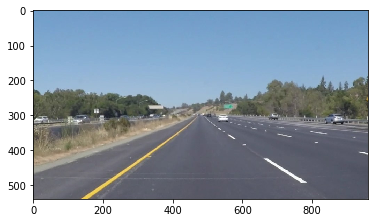

In [2]:
img = cv2.imread('test_images/solidYellowLeft.jpg', cv2.IMREAD_COLOR)

# This is to compensate for the fact that 
# opencv image layers are stored in reverse order - BGR
# @alsosee https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)



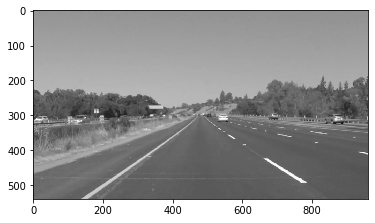

In [3]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cmap, vmin, vmax allow to print image as human expects it
plt.imshow(img_grey, cmap=cm.gray, vmin=0, vmax=255)

## Apply gradient filter to identify edges

Gradient filter can be applied to the grey scale image to identify
points on the where color intensity changes the most. 

On this example image these we can expect bright road lines to be picked 
up by the filter. 

Application of the GaussianBlur prior to Edge detection
reduces number of edgets that will be identified in the next step.

In [4]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
img_blur = cv2.GaussianBlur(img_grey,(kernel_size, kernel_size), 0)

In [5]:

thresholds = [(50, 150), (50, 200), (30, 200), (70, 200), 
              (50, 180), (50, 220), (50, 250),
              (100, 150), (100, 200), (100, 250),
              (150, 150), (150, 200), (150, 250)]


for l, h in thresholds:
    img_gradient = cv2.Canny(img_blur, l, h)
    cv2.putText(
        img_gradient, 
        "Thresholds (l,h): {l}, {h}".format(l = l, h = h), 
        (50,50), 
        cv2.FONT_HERSHEY_SIMPLEX, 
        1, 
        255
    )
    cv2.imwrite(
        "writeup_images/img_canny_tunning_{l}_{h}.jpg".format(l = l, h = h), 
        img_gradient
    )


Thresholds | Lower 50 | Lower 100 | Lower 150
:-------|:--------------------------:|:--------------------------:|:--------------------------:
Upper 150 |![Canny 50 150](writeup_images/img_canny_tunning_50_150.jpg) | ![Canny 100 150](writeup_images/img_canny_tunning_100_150.jpg) | ![Canny 150 200](writeup_images/img_canny_tunning_150_150.jpg)
Upper 200 |![Canny 50 200](writeup_images/img_canny_tunning_50_200.jpg) | ![Canny 100 150](writeup_images/img_canny_tunning_100_200.jpg) | ![Canny 150 200](writeup_images/img_canny_tunning_150_200.jpg)
Upper 250 |![Canny 50 250](writeup_images/img_canny_tunning_50_250.jpg) | ![Canny 100 250](writeup_images/img_canny_tunning_100_250.jpg) | ![Canny 150 250](writeup_images/img_canny_tunning_150_250.jpg)


True

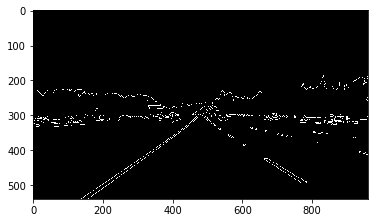

In [6]:
low_threshold = 50
high_threshold = 200
img_gradient = cv2.Canny(img_blur, low_threshold, high_threshold)

plt.imshow(img_gradient, cmap='Greys_r')


cv2.imwrite(
    "writeup_images/img_gradient.jpg", 
    img_gradient
)



## Reduce image scope

To detect lanes on the road it will help to reduce the view
of the camera to the road ahead of the car which can be asumed 
to be a triangle formed between:

 - left bottom corner of the image
 - right bottom corner
 - point in the middle by x and 2/3 from the bottom by y

243


True

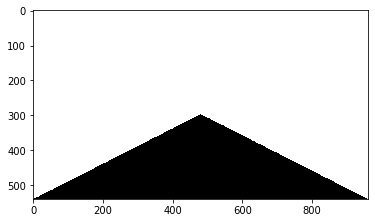

In [7]:
# Demo output of the `limit_view()` function
img_view_demo = np.copy(img_grey) * 0 #creating a blank to draw lines on
img_view_demo = limit_view(img_view_demo, color = 255) # remove color outside of the road view
plt.imshow(img_view_demo, cmap='Greys_r')

cv2.imwrite(
    "writeup_images/img_view_demo.jpg", 
    img_view_demo
)


243


True

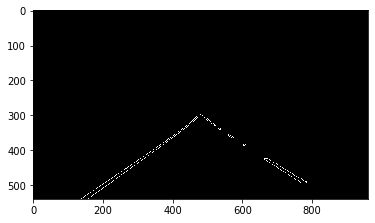

In [8]:
img_limited_view = limit_view(img_gradient)  
plt.imshow(img_limited_view, cmap='Greys_r')


cv2.imwrite(
    "writeup_images/img_limited_view.jpg", 
    img_limited_view
)

Lines detected: 9
Lines merged into: 2
[[136, 540, 414, 351]]
[[553, 351, 860, 540]]


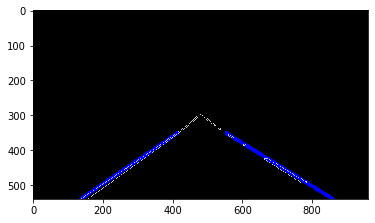

In [9]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi / 180
threshold = 50
min_line_length = 100
max_line_gap = 50

line_image = np.copy(img_limited_view) * 0 #creating a blank to draw lines on

# Run Hough on edge detected image
# OpenCV contains explanation of theory and parameters for HoughLinesP
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLinesP(
    img_limited_view, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

print("Lines detected: {lines}".format(lines = len(lines)))
                  
lines_output = merge_lines(lines)


print("Lines merged into: {output}".format(output = len(lines_output)))

height, width = img_grey.shape

# Iterate over the output "lines" and draw lines on the blank
for line in lines_output:
    el = extend_line(line, height, width)
    print(el)
    for x1, y1, x2, y2 in el:
        cv2.line(line_image, (x1, y1), (x2, y2), 255, 10)
        
        
plt.imshow(line_image)        
        
# Create a "color" binary image to combine with line image
color_edges = np.dstack((img_limited_view, img_limited_view, img_limited_view)) 

plt.imshow(color_edges)
line_image = cv2.merge((np.copy(img_limited_view) * 0, np.copy(img_limited_view) * 0, line_image))
# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

## Result 

Now we can combine lines derived from the pipeline above with original image to visually evaulate performance of the algorithm. 
        
In this example result is only partially satisfactory:

* Continious line on the right side is identified completely
* First section of the broken line on the left side is identified


However, most of segments of the broken line on the left side are undetected. 

There are possible ares for research to improve this:

 * Apply Canny edge detection to the relevant part of the image with different threshold level
 * Apply line detection iteratively over the depth of the image with different threshold levels
   to capture smaller 
 * Interpolate broken lines using the perspective geometry. This pottentially can inform about the shape of the lane based on the other line(s)

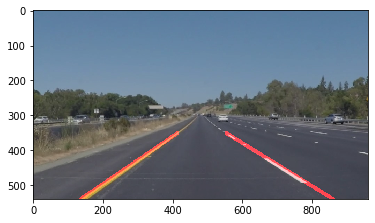

In [10]:
img_demo = img.copy()
img_demo = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
img_demo_color = cv2.cvtColor(img_demo, cv2.COLOR_BGR2RGB)
plt.imshow(img_demo_color)

243
Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.646791765825874 to 32.646791765825874, pass threshold: True


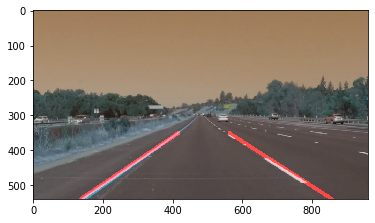

In [11]:
img = cv2.imread('test_images/solidYellowLeft.jpg', cv2.IMREAD_COLOR)

res = img_demo2 = process_image(img)
plt.imshow(res)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

243


t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Angle is updated from -31.12500126448983 to 31.12500126448984, pass threshold: True
Angle is updated from 34.11447294534126 to 34.11447294534126, pass threshold: True
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

243


t:   0%|          | 2/681 [00:00<02:00,  5.66it/s, now=None]

Angle is updated from -31.12500126448983 to 31.12500126448984, pass threshold: True
Angle is updated from 34.11447294534126 to 34.11447294534126, pass threshold: True
243


t:   0%|          | 3/681 [00:00<02:38,  4.29it/s, now=None]

Angle is updated from -31.287763141467973 to 31.287763141467963, pass threshold: True
Angle is updated from 34.01934998982646 to 34.01934998982646, pass threshold: True
243


t:   1%|          | 4/681 [00:01<02:58,  3.79it/s, now=None]

Angle is updated from -31.369718889494735 to 31.36971888949472, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:   1%|          | 5/681 [00:01<03:13,  3.49it/s, now=None]

Angle is updated from -31.785341414364645 to 31.785341414364638, pass threshold: True
Angle is updated from 33.73676334246508 to 33.73676334246508, pass threshold: True
243


t:   1%|          | 6/681 [00:01<03:23,  3.32it/s, now=None]

Angle is updated from -32.12499844038753 to 32.124998440387515, pass threshold: True
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
243


t:   1%|          | 7/681 [00:02<03:29,  3.21it/s, now=None]

Angle is updated from -32.12499844038753 to 32.124998440387515, pass threshold: True
Angle is updated from 34.79361858908568 to 34.79361858908568, pass threshold: True
243


t:   1%|          | 8/681 [00:02<03:34,  3.13it/s, now=None]

Angle is updated from -32.03947768755408 to 32.0394776875541, pass threshold: True
Angle is updated from 34.402664854976436 to 34.402664854976436, pass threshold: True
243


t:   1%|▏         | 9/681 [00:02<03:37,  3.09it/s, now=None]

Angle is updated from -32.82408748220024 to 32.82408748220024, pass threshold: True
Angle is updated from 33.274887984834926 to 33.274887984834926, pass threshold: True
243


t:   1%|▏         | 10/681 [00:03<03:39,  3.05it/s, now=None]

Angle is updated from -32.55878131556152 to 32.55878131556153, pass threshold: True
Angle is updated from 33.45828974694667 to 33.45828974694667, pass threshold: True
243


t:   2%|▏         | 11/681 [00:03<03:41,  3.02it/s, now=None]

Angle is updated from -32.82408748220024 to 32.82408748220024, pass threshold: True
Angle is updated from 33.45828974694667 to 33.45828974694667, pass threshold: True
243


t:   2%|▏         | 12/681 [00:03<03:43,  2.99it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 33.09325807475061 to 33.09325807475061, pass threshold: True
243


t:   2%|▏         | 13/681 [00:04<03:44,  2.98it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:   2%|▏         | 14/681 [00:04<03:44,  2.97it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 33.274887984834926 to 33.274887984834926, pass threshold: True
243


t:   2%|▏         | 15/681 [00:04<03:44,  2.97it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:   2%|▏         | 16/681 [00:05<03:43,  2.97it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:   2%|▏         | 17/681 [00:05<03:44,  2.96it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:   3%|▎         | 18/681 [00:05<03:43,  2.96it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 33.45828974694667 to 33.45828974694667, pass threshold: True
243


t:   3%|▎         | 19/681 [00:06<03:43,  2.97it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 34.01934998982646 to 34.01934998982646, pass threshold: True
243


t:   3%|▎         | 20/681 [00:06<03:46,  2.92it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 33.92469266623727 to 33.92469266623727, pass threshold: True
243


t:   3%|▎         | 21/681 [00:06<03:43,  2.95it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 33.8304980769171 to 33.8304980769171, pass threshold: True
243


t:   3%|▎         | 22/681 [00:07<03:41,  2.97it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:   3%|▎         | 23/681 [00:07<03:42,  2.96it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:   4%|▎         | 24/681 [00:07<03:41,  2.97it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:   4%|▎         | 25/681 [00:08<03:39,  2.98it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:   4%|▍         | 26/681 [00:08<03:38,  3.00it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 33.64348560167958 to 33.64348560167958, pass threshold: True
243


t:   4%|▍         | 27/681 [00:08<03:38,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
Angle is updated from -40.92438772132263 to 40.92438772132263, pass threshold: True
243


t:   4%|▍         | 28/681 [00:09<03:37,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
Angle is updated from -41.05481377096244 to 41.054813770962426, pass threshold: True
243


t:   4%|▍         | 29/681 [00:09<03:36,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
243


t:   4%|▍         | 30/681 [00:09<03:35,  3.02it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
Angle is updated from -37.31090840665584 to 37.31090840665584, pass threshold: True
243


t:   5%|▍         | 31/681 [00:10<03:34,  3.03it/s, now=None]

Angle is updated from -35.702202191216706 to 35.70220219121671, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:   5%|▍         | 32/681 [00:10<03:35,  3.01it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:   5%|▍         | 33/681 [00:10<03:35,  3.01it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 33.09325807475061 to 33.09325807475061, pass threshold: True
243


t:   5%|▍         | 34/681 [00:11<03:34,  3.01it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 32.82408748220024 to 32.82408748220024, pass threshold: True
243


t:   5%|▌         | 35/681 [00:11<03:35,  3.00it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
Angle is updated from -40.92438772132263 to 40.92438772132263, pass threshold: True
243


t:   5%|▌         | 36/681 [00:11<03:35,  3.00it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:   5%|▌         | 37/681 [00:12<03:33,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
Angle is updated from -38.45370921670597 to 38.45370921670596, pass threshold: True
243


t:   6%|▌         | 38/681 [00:12<03:33,  3.01it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:   6%|▌         | 39/681 [00:12<03:32,  3.02it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 29.212680842370215 to 29.212680842370215, pass threshold: True
243


t:   6%|▌         | 40/681 [00:13<03:31,  3.03it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:   6%|▌         | 41/681 [00:13<03:32,  3.02it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:   6%|▌         | 42/681 [00:13<03:31,  3.02it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:   6%|▋         | 43/681 [00:14<03:30,  3.03it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:   6%|▋         | 44/681 [00:14<03:32,  3.00it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:   7%|▋         | 45/681 [00:14<03:32,  2.99it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:   7%|▋         | 46/681 [00:15<03:31,  3.00it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:   7%|▋         | 47/681 [00:15<03:30,  3.01it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:   7%|▋         | 48/681 [00:15<03:29,  3.02it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:   7%|▋         | 49/681 [00:16<03:27,  3.04it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:   7%|▋         | 50/681 [00:16<03:27,  3.04it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:   7%|▋         | 51/681 [00:16<03:28,  3.02it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
243


t:   8%|▊         | 52/681 [00:17<03:28,  3.02it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 29.212680842370215 to 29.212680842370215, pass threshold: True
243


t:   8%|▊         | 53/681 [00:17<03:28,  3.02it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:   8%|▊         | 54/681 [00:17<03:28,  3.01it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 28.30075576600638 to 28.30075576600638, pass threshold: True
243


t:   8%|▊         | 55/681 [00:18<03:27,  3.01it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:   8%|▊         | 56/681 [00:18<03:26,  3.03it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:   8%|▊         | 57/681 [00:18<03:26,  3.02it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:   9%|▊         | 58/681 [00:19<03:25,  3.03it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
243


t:   9%|▊         | 59/681 [00:19<03:26,  3.02it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:   9%|▉         | 60/681 [00:19<03:26,  3.01it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 32.91337806129942 to 32.91337806129942, pass threshold: True
243


t:   9%|▉         | 61/681 [00:20<03:27,  2.99it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:   9%|▉         | 62/681 [00:20<03:26,  2.99it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:   9%|▉         | 63/681 [00:20<03:26,  2.99it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:   9%|▉         | 64/681 [00:21<03:25,  3.01it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  10%|▉         | 65/681 [00:21<03:26,  2.99it/s, now=None]

Angle is updated from -36.65273211782626 to 36.65273211782625, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  10%|▉         | 66/681 [00:21<03:24,  3.00it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  10%|▉         | 67/681 [00:22<03:24,  3.01it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  10%|▉         | 68/681 [00:22<03:23,  3.01it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 33.09325807475061 to 33.09325807475061, pass threshold: True
243


t:  10%|█         | 69/681 [00:22<03:23,  3.01it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 34.30612743437902 to 34.30612743437902, pass threshold: True
243


t:  10%|█         | 70/681 [00:23<03:24,  2.98it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 33.8304980769171 to 33.8304980769171, pass threshold: True
243


t:  10%|█         | 71/681 [00:23<03:23,  2.99it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 33.73676334246508 to 33.73676334246508, pass threshold: True
243


t:  11%|█         | 72/681 [00:23<03:23,  2.99it/s, now=None]

Angle is updated from -35.49675224213945 to 35.49675224213945, pass threshold: True
Angle is updated from 33.45828974694667 to 33.45828974694667, pass threshold: True
243


t:  11%|█         | 73/681 [00:24<03:22,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:  11%|█         | 74/681 [00:24<03:21,  3.01it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:  11%|█         | 75/681 [00:24<03:22,  2.99it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  11%|█         | 76/681 [00:25<03:21,  3.01it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
243


t:  11%|█▏        | 77/681 [00:25<03:21,  3.00it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 32.646791765825874 to 32.646791765825874, pass threshold: True
243


t:  11%|█▏        | 78/681 [00:25<03:23,  2.97it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  12%|█▏        | 79/681 [00:26<03:22,  2.97it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:  12%|█▏        | 80/681 [00:26<03:22,  2.96it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  12%|█▏        | 81/681 [00:26<03:22,  2.96it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 34.01934998982646 to 34.01934998982646, pass threshold: True
243


t:  12%|█▏        | 82/681 [00:27<03:22,  2.96it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 34.21006444874871 to 34.21006444874871, pass threshold: True
243


t:  12%|█▏        | 83/681 [00:27<03:22,  2.95it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 34.21006444874871 to 34.21006444874871, pass threshold: True
243


t:  12%|█▏        | 84/681 [00:27<03:22,  2.95it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:  12%|█▏        | 85/681 [00:28<03:23,  2.93it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:  13%|█▎        | 86/681 [00:28<03:24,  2.90it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:  13%|█▎        | 87/681 [00:28<03:24,  2.91it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 32.646791765825874 to 32.646791765825874, pass threshold: True
243


t:  13%|█▎        | 88/681 [00:29<03:22,  2.94it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  13%|█▎        | 89/681 [00:29<03:21,  2.94it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  13%|█▎        | 90/681 [00:29<03:21,  2.94it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  13%|█▎        | 91/681 [00:30<03:21,  2.93it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  14%|█▎        | 92/681 [00:30<03:19,  2.95it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  14%|█▎        | 93/681 [00:30<03:17,  2.97it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  14%|█▍        | 94/681 [00:31<03:18,  2.96it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 34.01934998982646 to 34.01934998982646, pass threshold: True
243


t:  14%|█▍        | 95/681 [00:31<03:18,  2.96it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 36.979310204471616 to 36.979310204471616, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  14%|█▍        | 96/681 [00:31<03:18,  2.95it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:  14%|█▍        | 97/681 [00:32<03:17,  2.96it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:  14%|█▍        | 98/681 [00:32<03:16,  2.96it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 33.73676334246508 to 33.73676334246508, pass threshold: True
243


t:  15%|█▍        | 99/681 [00:32<03:15,  2.97it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:  15%|█▍        | 100/681 [00:33<03:14,  2.98it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.82408748220024 to 32.82408748220024, pass threshold: True
243


t:  15%|█▍        | 101/681 [00:33<03:15,  2.97it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 32.7352262721076 to 32.7352262721076, pass threshold: True
Angle is updated from -39.16816039038884 to 39.168160390388834, pass threshold: True
243


t:  15%|█▍        | 102/681 [00:33<03:15,  2.97it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 32.646791765825874 to 32.646791765825874, pass threshold: True
243


t:  15%|█▌        | 103/681 [00:34<03:15,  2.95it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.646791765825874 to 32.646791765825874, pass threshold: True
243


t:  15%|█▌        | 104/681 [00:34<03:15,  2.96it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  15%|█▌        | 105/681 [00:34<03:14,  2.97it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  16%|█▌        | 106/681 [00:35<03:16,  2.93it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  16%|█▌        | 107/681 [00:35<03:16,  2.92it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 33.09325807475061 to 33.09325807475061, pass threshold: True
243


t:  16%|█▌        | 108/681 [00:35<03:15,  2.94it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 33.55066201149997 to 33.55066201149997, pass threshold: True
243


t:  16%|█▌        | 109/681 [00:36<03:13,  2.96it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  16%|█▌        | 110/681 [00:36<03:25,  2.78it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:  16%|█▋        | 111/681 [00:37<03:22,  2.81it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  16%|█▋        | 112/681 [00:37<03:21,  2.82it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  17%|█▋        | 113/681 [00:37<03:19,  2.84it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  17%|█▋        | 114/681 [00:38<03:18,  2.86it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:  17%|█▋        | 115/681 [00:38<03:38,  2.59it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  17%|█▋        | 116/681 [00:38<03:32,  2.66it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.82408748220024 to 32.82408748220024, pass threshold: True
243


t:  17%|█▋        | 117/681 [00:39<03:31,  2.67it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  17%|█▋        | 118/681 [00:39<03:34,  2.62it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  17%|█▋        | 119/681 [00:40<03:30,  2.68it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  18%|█▊        | 120/681 [00:40<03:24,  2.74it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:  18%|█▊        | 121/681 [00:40<03:20,  2.79it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  18%|█▊        | 122/681 [00:41<03:16,  2.84it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  18%|█▊        | 123/681 [00:41<03:13,  2.88it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  18%|█▊        | 124/681 [00:41<03:11,  2.90it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  18%|█▊        | 125/681 [00:42<03:10,  2.92it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  19%|█▊        | 126/681 [00:42<03:09,  2.93it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  19%|█▊        | 127/681 [00:42<03:08,  2.95it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  19%|█▉        | 128/681 [00:43<03:06,  2.96it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  19%|█▉        | 129/681 [00:43<03:07,  2.95it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  19%|█▉        | 130/681 [00:43<03:08,  2.93it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  19%|█▉        | 131/681 [00:44<03:07,  2.94it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  19%|█▉        | 132/681 [00:44<03:07,  2.93it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  20%|█▉        | 133/681 [00:44<03:06,  2.94it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 33.36636600105956 to 33.36636600105956, pass threshold: True
243


t:  20%|█▉        | 134/681 [00:45<03:06,  2.93it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  20%|█▉        | 135/681 [00:45<03:05,  2.94it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 33.09325807475061 to 33.09325807475061, pass threshold: True
243


t:  20%|█▉        | 136/681 [00:45<03:04,  2.95it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  20%|██        | 137/681 [00:46<03:04,  2.95it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  20%|██        | 138/681 [00:46<03:03,  2.95it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  20%|██        | 139/681 [00:46<03:03,  2.95it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  21%|██        | 140/681 [00:47<03:03,  2.95it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 33.274887984834926 to 33.274887984834926, pass threshold: True
243


t:  21%|██        | 141/681 [00:47<03:02,  2.96it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  21%|██        | 142/681 [00:47<03:02,  2.95it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  21%|██        | 143/681 [00:48<03:01,  2.96it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  21%|██        | 144/681 [00:48<03:01,  2.96it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  21%|██▏       | 145/681 [00:48<03:00,  2.97it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  21%|██▏       | 146/681 [00:49<03:00,  2.97it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  22%|██▏       | 147/681 [00:49<03:00,  2.96it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  22%|██▏       | 148/681 [00:49<03:00,  2.96it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  22%|██▏       | 149/681 [00:50<02:59,  2.96it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  22%|██▏       | 150/681 [00:50<02:58,  2.97it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 32.91337806129942 to 32.91337806129942, pass threshold: True
243


t:  22%|██▏       | 151/681 [00:50<02:58,  2.97it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  22%|██▏       | 152/681 [00:51<02:57,  2.98it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  22%|██▏       | 153/681 [00:51<02:57,  2.98it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  23%|██▎       | 154/681 [00:51<02:55,  3.00it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  23%|██▎       | 155/681 [00:52<02:56,  2.99it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  23%|██▎       | 156/681 [00:52<02:58,  2.95it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  23%|██▎       | 157/681 [00:52<02:59,  2.93it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  23%|██▎       | 158/681 [00:53<02:57,  2.94it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  23%|██▎       | 159/681 [00:53<02:56,  2.96it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  23%|██▎       | 160/681 [00:53<02:55,  2.96it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  24%|██▎       | 161/681 [00:54<02:55,  2.96it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  24%|██▍       | 162/681 [00:54<02:54,  2.97it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  24%|██▍       | 163/681 [00:54<02:53,  2.98it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
Angle is updated from -19.290046219188735 to 19.290046219188724, pass threshold: False
243


t:  24%|██▍       | 164/681 [00:55<02:53,  2.97it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  24%|██▍       | 165/681 [00:55<02:53,  2.97it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
Angle is updated from -19.15858026729483 to 19.158580267294838, pass threshold: False
243


t:  24%|██▍       | 166/681 [00:55<02:53,  2.97it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  25%|██▍       | 167/681 [00:56<02:53,  2.97it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  25%|██▍       | 168/681 [00:56<02:54,  2.95it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  25%|██▍       | 169/681 [00:56<02:58,  2.87it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  25%|██▍       | 170/681 [00:57<02:56,  2.90it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  25%|██▌       | 171/681 [00:57<02:54,  2.93it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  25%|██▌       | 172/681 [00:57<02:52,  2.95it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  25%|██▌       | 173/681 [00:58<02:54,  2.91it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  26%|██▌       | 174/681 [00:58<02:57,  2.86it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  26%|██▌       | 175/681 [00:59<02:55,  2.88it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  26%|██▌       | 176/681 [00:59<02:56,  2.86it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  26%|██▌       | 177/681 [00:59<02:55,  2.87it/s, now=None]

Angle is updated from -35.702202191216706 to 35.70220219121671, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  26%|██▌       | 178/681 [01:00<02:54,  2.88it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  26%|██▋       | 179/681 [01:00<02:52,  2.91it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  26%|██▋       | 180/681 [01:00<02:51,  2.93it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
243


t:  27%|██▋       | 181/681 [01:01<02:50,  2.94it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  27%|██▋       | 182/681 [01:01<02:50,  2.92it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 28.85566121971652 to 28.85566121971652, pass threshold: True
243


t:  27%|██▋       | 183/681 [01:01<02:49,  2.94it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  27%|██▋       | 184/681 [01:02<02:47,  2.96it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  27%|██▋       | 185/681 [01:02<02:47,  2.96it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  27%|██▋       | 186/681 [01:02<02:47,  2.96it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  27%|██▋       | 187/681 [01:03<02:46,  2.97it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  28%|██▊       | 188/681 [01:03<02:44,  2.99it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  28%|██▊       | 189/681 [01:03<02:44,  3.00it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
243


t:  28%|██▊       | 190/681 [01:04<02:43,  3.00it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  28%|██▊       | 191/681 [01:04<02:42,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
243


t:  28%|██▊       | 192/681 [01:04<02:42,  3.01it/s, now=None]

Angle is updated from -36.437756654776315 to 36.43775665477631, pass threshold: True
Angle is updated from 28.785212416617036 to 28.785212416617036, pass threshold: True
243


t:  28%|██▊       | 193/681 [01:05<02:41,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 28.575741969034805 to 28.575741969034805, pass threshold: True
243


t:  28%|██▊       | 194/681 [01:05<02:41,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
243


t:  29%|██▊       | 195/681 [01:05<02:41,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  29%|██▉       | 196/681 [01:06<02:40,  3.01it/s, now=None]

Angle is updated from -36.437756654776315 to 36.43775665477631, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  29%|██▉       | 197/681 [01:06<02:40,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
243


t:  29%|██▉       | 198/681 [01:06<02:40,  3.00it/s, now=None]

Angle is updated from -36.65273211782626 to 36.65273211782625, pass threshold: True
Angle is updated from 28.369046293278583 to 28.369046293278583, pass threshold: True
243


t:  29%|██▉       | 199/681 [01:07<02:41,  2.99it/s, now=None]

Angle is updated from -36.437756654776315 to 36.43775665477631, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  29%|██▉       | 200/681 [01:07<02:40,  2.99it/s, now=None]

Angle is updated from -36.437756654776315 to 36.43775665477631, pass threshold: True
Angle is updated from 29.212680842370215 to 29.212680842370215, pass threshold: True
243


t:  30%|██▉       | 201/681 [01:07<02:39,  3.00it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  30%|██▉       | 202/681 [01:08<02:39,  3.01it/s, now=None]

Angle is updated from -37.422572910792184 to 37.422572910792184, pass threshold: True
Angle is updated from 29.06891016108024 to 29.06891016108024, pass threshold: True
243


t:  30%|██▉       | 203/681 [01:08<02:38,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 28.575741969034805 to 28.575741969034805, pass threshold: True
243


t:  30%|██▉       | 204/681 [01:08<02:46,  2.87it/s, now=None]

Angle is updated from -36.76103942436479 to 36.76103942436478, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  30%|███       | 205/681 [01:09<02:44,  2.90it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  30%|███       | 206/681 [01:09<02:41,  2.94it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  30%|███       | 207/681 [01:09<02:40,  2.96it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  31%|███       | 208/681 [01:10<02:42,  2.90it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  31%|███       | 209/681 [01:10<02:41,  2.92it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 29.504144144220426 to 29.504144144220426, pass threshold: True
243


t:  31%|███       | 210/681 [01:10<02:40,  2.94it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  31%|███       | 211/681 [01:11<02:41,  2.90it/s, now=None]

Angle is updated from -35.702202191216706 to 35.70220219121671, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  31%|███       | 212/681 [01:11<02:42,  2.89it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  31%|███▏      | 213/681 [01:11<02:40,  2.91it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  31%|███▏      | 214/681 [01:12<02:39,  2.93it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  32%|███▏      | 215/681 [01:12<02:37,  2.95it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  32%|███▏      | 216/681 [01:12<02:36,  2.97it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  32%|███▏      | 217/681 [01:13<02:36,  2.97it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
243


t:  32%|███▏      | 218/681 [01:13<02:35,  2.97it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  32%|███▏      | 219/681 [01:13<02:35,  2.97it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
243


t:  32%|███▏      | 220/681 [01:14<02:34,  2.98it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  32%|███▏      | 221/681 [01:14<02:34,  2.98it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  33%|███▎      | 222/681 [01:14<02:33,  2.98it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  33%|███▎      | 223/681 [01:15<02:33,  2.99it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  33%|███▎      | 224/681 [01:15<02:32,  2.99it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  33%|███▎      | 225/681 [01:15<02:31,  3.00it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  33%|███▎      | 226/681 [01:16<02:31,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  33%|███▎      | 227/681 [01:16<02:31,  3.00it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  33%|███▎      | 228/681 [01:16<02:31,  2.98it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  34%|███▎      | 229/681 [01:17<02:32,  2.97it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  34%|███▍      | 230/681 [01:17<02:31,  2.97it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  34%|███▍      | 231/681 [01:17<02:30,  2.99it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  34%|███▍      | 232/681 [01:18<02:29,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  34%|███▍      | 233/681 [01:18<02:29,  3.01it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  34%|███▍      | 234/681 [01:18<02:28,  3.00it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  35%|███▍      | 235/681 [01:19<02:28,  3.01it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  35%|███▍      | 236/681 [01:19<02:28,  2.99it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  35%|███▍      | 237/681 [01:19<02:29,  2.98it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  35%|███▍      | 238/681 [01:20<02:28,  2.98it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  35%|███▌      | 239/681 [01:20<02:27,  3.00it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  35%|███▌      | 240/681 [01:20<02:26,  3.01it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  35%|███▌      | 241/681 [01:21<02:26,  3.00it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  36%|███▌      | 242/681 [01:21<02:26,  2.99it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  36%|███▌      | 243/681 [01:21<02:26,  2.99it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  36%|███▌      | 244/681 [01:22<02:25,  3.00it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  36%|███▌      | 245/681 [01:22<02:26,  2.98it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
243


t:  36%|███▌      | 246/681 [01:22<02:27,  2.96it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  36%|███▋      | 247/681 [01:23<02:25,  2.98it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  36%|███▋      | 248/681 [01:23<02:24,  3.00it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  37%|███▋      | 249/681 [01:23<02:23,  3.00it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  37%|███▋      | 250/681 [01:24<02:23,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  37%|███▋      | 251/681 [01:24<02:23,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  37%|███▋      | 252/681 [01:24<02:22,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  37%|███▋      | 253/681 [01:25<02:23,  2.98it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  37%|███▋      | 254/681 [01:25<02:22,  2.99it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  37%|███▋      | 255/681 [01:25<02:21,  3.00it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  38%|███▊      | 256/681 [01:26<02:21,  3.00it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  38%|███▊      | 257/681 [01:26<02:21,  3.00it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  38%|███▊      | 258/681 [01:26<02:20,  3.00it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  38%|███▊      | 259/681 [01:27<02:21,  2.98it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  38%|███▊      | 260/681 [01:27<02:20,  2.99it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  38%|███▊      | 261/681 [01:27<02:20,  2.99it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  38%|███▊      | 262/681 [01:28<02:19,  3.01it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  39%|███▊      | 263/681 [01:28<02:19,  3.00it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  39%|███▉      | 264/681 [01:28<02:18,  3.02it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
Angle is updated from 24.69552629003956 to 24.69552629003956, pass threshold: False
243


t:  39%|███▉      | 265/681 [01:29<02:17,  3.01it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  39%|███▉      | 266/681 [01:29<02:18,  3.00it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  39%|███▉      | 267/681 [01:29<02:17,  3.01it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  39%|███▉      | 268/681 [01:30<02:17,  3.00it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
Angle is updated from 29.504144144220426 to 29.504144144220426, pass threshold: True
243


t:  40%|███▉      | 269/681 [01:30<02:18,  2.98it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 28.506537567992368 to 28.506537567992368, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  40%|███▉      | 270/681 [01:30<02:17,  2.98it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  40%|███▉      | 271/681 [01:31<02:18,  2.97it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 28.785212416617036 to 28.785212416617036, pass threshold: True
243


t:  40%|███▉      | 272/681 [01:31<02:17,  2.96it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 29.06891016108024 to 29.06891016108024, pass threshold: True
243


t:  40%|████      | 273/681 [01:31<02:17,  2.98it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  40%|████      | 274/681 [01:32<02:15,  3.00it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  40%|████      | 275/681 [01:32<02:15,  3.00it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 29.06891016108024 to 29.06891016108024, pass threshold: True
243


t:  41%|████      | 276/681 [01:32<02:14,  3.01it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
243


t:  41%|████      | 277/681 [01:33<02:14,  3.01it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  41%|████      | 278/681 [01:33<02:14,  3.00it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
243


t:  41%|████      | 279/681 [01:33<02:14,  2.99it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
Angle is updated from 25.74070835623284 to 25.74070835623284, pass threshold: True
243


t:  41%|████      | 280/681 [01:34<02:13,  3.01it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
243


t:  41%|████▏     | 281/681 [01:34<02:12,  3.01it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
243


t:  41%|████▏     | 282/681 [01:34<02:12,  3.01it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.06891016108024 to 29.06891016108024, pass threshold: True
243


t:  42%|████▏     | 283/681 [01:35<02:11,  3.02it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 29.06891016108024 to 29.06891016108024, pass threshold: True
243


t:  42%|████▏     | 284/681 [01:35<02:11,  3.02it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  42%|████▏     | 285/681 [01:35<02:11,  3.01it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  42%|████▏     | 286/681 [01:36<02:11,  3.02it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  42%|████▏     | 287/681 [01:36<02:10,  3.01it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  42%|████▏     | 288/681 [01:36<02:09,  3.03it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  42%|████▏     | 289/681 [01:37<02:09,  3.03it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
Angle is updated from 1.070983293816873 to 1.070983293816873, pass threshold: False
243


t:  43%|████▎     | 290/681 [01:37<02:09,  3.03it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
Angle is updated from 2.4473802669380653 to 2.4473802669380653, pass threshold: False
243


t:  43%|████▎     | 291/681 [01:37<02:09,  3.02it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
Angle is updated from -0.8883447855624074 to 0.8883447855623956, pass threshold: False
243


t:  43%|████▎     | 292/681 [01:38<02:09,  3.01it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
Angle is updated from 3.457721548655339 to 3.457721548655339, pass threshold: False
243


t:  43%|████▎     | 293/681 [01:38<02:08,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
Angle is updated from 2.679130685471774 to 2.679130685471774, pass threshold: False
243


t:  43%|████▎     | 294/681 [01:38<02:08,  3.01it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  43%|████▎     | 295/681 [01:39<02:08,  3.01it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  43%|████▎     | 296/681 [01:39<02:08,  3.00it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  44%|████▎     | 297/681 [01:39<02:07,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.504144144220426 to 29.504144144220426, pass threshold: True
243


t:  44%|████▍     | 298/681 [01:40<02:07,  3.01it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  44%|████▍     | 299/681 [01:40<02:06,  3.02it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  44%|████▍     | 300/681 [01:40<02:06,  3.02it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  44%|████▍     | 301/681 [01:41<02:05,  3.02it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  44%|████▍     | 302/681 [01:41<02:05,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  44%|████▍     | 303/681 [01:41<02:05,  3.01it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  45%|████▍     | 304/681 [01:42<02:04,  3.02it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  45%|████▍     | 305/681 [01:42<02:04,  3.02it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  45%|████▍     | 306/681 [01:42<02:04,  3.02it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  45%|████▌     | 307/681 [01:43<02:04,  3.02it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  45%|████▌     | 308/681 [01:43<02:03,  3.02it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  45%|████▌     | 309/681 [01:43<02:03,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  46%|████▌     | 310/681 [01:44<02:03,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  46%|████▌     | 311/681 [01:44<02:03,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  46%|████▌     | 312/681 [01:44<02:02,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  46%|████▌     | 313/681 [01:45<02:02,  3.01it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  46%|████▌     | 314/681 [01:45<02:01,  3.02it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  46%|████▋     | 315/681 [01:45<02:01,  3.01it/s, now=None]

Angle is updated from -36.437756654776315 to 36.43775665477631, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  46%|████▋     | 316/681 [01:46<02:00,  3.02it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  47%|████▋     | 317/681 [01:46<02:00,  3.03it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  47%|████▋     | 318/681 [01:46<02:00,  3.02it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  47%|████▋     | 319/681 [01:47<01:59,  3.02it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  47%|████▋     | 320/681 [01:47<02:00,  3.00it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  47%|████▋     | 321/681 [01:47<01:59,  3.00it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  47%|████▋     | 322/681 [01:48<01:59,  3.00it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
243


t:  47%|████▋     | 323/681 [01:48<01:59,  2.99it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  48%|████▊     | 324/681 [01:48<01:58,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  48%|████▊     | 325/681 [01:49<01:58,  3.01it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  48%|████▊     | 326/681 [01:49<01:58,  3.00it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  48%|████▊     | 327/681 [01:49<01:58,  3.00it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  48%|████▊     | 328/681 [01:50<01:57,  3.00it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  48%|████▊     | 329/681 [01:50<01:57,  3.01it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  48%|████▊     | 330/681 [01:50<01:56,  3.00it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  49%|████▊     | 331/681 [01:51<01:56,  3.00it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  49%|████▉     | 332/681 [01:51<01:55,  3.01it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  49%|████▉     | 333/681 [01:51<01:55,  3.01it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  49%|████▉     | 334/681 [01:52<01:55,  2.99it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  49%|████▉     | 335/681 [01:52<01:55,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  49%|████▉     | 336/681 [01:52<01:55,  2.99it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  49%|████▉     | 337/681 [01:53<01:55,  2.98it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  50%|████▉     | 338/681 [01:53<01:55,  2.98it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  50%|████▉     | 339/681 [01:53<01:54,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  50%|████▉     | 340/681 [01:54<01:54,  2.99it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  50%|█████     | 341/681 [01:54<01:53,  3.00it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  50%|█████     | 342/681 [01:54<01:52,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  50%|█████     | 343/681 [01:55<01:52,  3.02it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  51%|█████     | 344/681 [01:55<01:51,  3.02it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  51%|█████     | 345/681 [01:55<01:51,  3.02it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  51%|█████     | 346/681 [01:56<01:51,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  51%|█████     | 347/681 [01:56<01:51,  3.00it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  51%|█████     | 348/681 [01:56<01:50,  3.00it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  51%|█████     | 349/681 [01:57<01:51,  2.99it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  51%|█████▏    | 350/681 [01:57<01:50,  2.99it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  52%|█████▏    | 351/681 [01:57<01:49,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  52%|█████▏    | 352/681 [01:58<01:49,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
Angle is updated from 26.933507702415692 to 26.933507702415692, pass threshold: True
243


t:  52%|█████▏    | 353/681 [01:58<01:49,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
Angle is updated from 26.933507702415692 to 26.933507702415692, pass threshold: True
243


t:  52%|█████▏    | 354/681 [01:58<01:49,  3.00it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  52%|█████▏    | 355/681 [01:59<01:48,  3.01it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  52%|█████▏    | 356/681 [01:59<01:48,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  52%|█████▏    | 357/681 [01:59<01:48,  3.00it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  53%|█████▎    | 358/681 [02:00<01:47,  3.01it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  53%|█████▎    | 359/681 [02:00<01:47,  3.01it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  53%|█████▎    | 360/681 [02:00<01:46,  3.01it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  53%|█████▎    | 361/681 [02:01<01:46,  3.01it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  53%|█████▎    | 362/681 [02:01<01:46,  3.00it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
Angle is updated from -39.047540562032474 to 39.04754056203248, pass threshold: True
243


t:  53%|█████▎    | 363/681 [02:01<01:46,  3.00it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  53%|█████▎    | 364/681 [02:02<01:45,  3.00it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
Angle is updated from -39.16816039038884 to 39.168160390388834, pass threshold: True
Angle is updated from 25.85554218880334 to 25.85554218880334, pass threshold: True
243


t:  54%|█████▎    | 365/681 [02:02<01:45,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  54%|█████▎    | 366/681 [02:02<01:44,  3.00it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  54%|█████▍    | 367/681 [02:03<01:44,  3.00it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  54%|█████▍    | 368/681 [02:03<01:44,  3.00it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  54%|█████▍    | 369/681 [02:03<01:43,  3.01it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 28.645254669489244 to 28.645254669489244, pass threshold: True
243


t:  54%|█████▍    | 370/681 [02:04<01:43,  3.01it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
243


t:  54%|█████▍    | 371/681 [02:04<01:43,  3.00it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  55%|█████▍    | 372/681 [02:04<01:43,  3.00it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  55%|█████▍    | 373/681 [02:05<01:42,  3.00it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  55%|█████▍    | 374/681 [02:05<01:42,  3.01it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  55%|█████▌    | 375/681 [02:05<01:41,  3.02it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  55%|█████▌    | 376/681 [02:06<01:40,  3.02it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  55%|█████▌    | 377/681 [02:06<01:41,  3.01it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
Angle is updated from 26.74810416292146 to 26.74810416292146, pass threshold: True
243


t:  56%|█████▌    | 378/681 [02:06<01:40,  3.01it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  56%|█████▌    | 379/681 [02:07<01:40,  3.01it/s, now=None]

Angle is updated from -34.69515353123397 to 34.695153531233984, pass threshold: True
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
243


t:  56%|█████▌    | 380/681 [02:07<01:40,  3.01it/s, now=None]

Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
243


t:  56%|█████▌    | 381/681 [02:07<01:39,  3.02it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  56%|█████▌    | 382/681 [02:08<01:39,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  56%|█████▌    | 383/681 [02:08<01:38,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  56%|█████▋    | 384/681 [02:08<01:38,  3.01it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  57%|█████▋    | 385/681 [02:09<01:38,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  57%|█████▋    | 386/681 [02:09<01:38,  2.99it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  57%|█████▋    | 387/681 [02:09<01:38,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  57%|█████▋    | 388/681 [02:10<01:37,  3.00it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  57%|█████▋    | 389/681 [02:10<01:37,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  57%|█████▋    | 390/681 [02:10<01:37,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  57%|█████▋    | 391/681 [02:11<01:36,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  58%|█████▊    | 392/681 [02:11<01:36,  2.99it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  58%|█████▊    | 393/681 [02:11<01:36,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  58%|█████▊    | 394/681 [02:12<01:35,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  58%|█████▊    | 395/681 [02:12<01:35,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  58%|█████▊    | 396/681 [02:12<01:35,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  58%|█████▊    | 397/681 [02:13<01:34,  3.01it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:  58%|█████▊    | 398/681 [02:13<01:34,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  59%|█████▊    | 399/681 [02:13<01:34,  2.99it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  59%|█████▊    | 400/681 [02:14<01:33,  3.00it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  59%|█████▉    | 401/681 [02:14<01:33,  2.99it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  59%|█████▉    | 402/681 [02:14<01:33,  2.99it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:  59%|█████▉    | 403/681 [02:15<01:33,  2.98it/s, now=None]

Angle is updated from -33.18385292716073 to 33.18385292716073, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  59%|█████▉    | 404/681 [02:15<01:32,  2.99it/s, now=None]

Angle is updated from -32.91337806129942 to 32.913378061299426, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  59%|█████▉    | 405/681 [02:15<01:32,  3.00it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  60%|█████▉    | 406/681 [02:16<01:31,  3.01it/s, now=None]

Angle is updated from -32.91337806129942 to 32.913378061299426, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  60%|█████▉    | 407/681 [02:16<01:30,  3.02it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  60%|█████▉    | 408/681 [02:16<01:31,  2.99it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  60%|██████    | 409/681 [02:17<01:30,  3.00it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  60%|██████    | 410/681 [02:17<01:29,  3.01it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  60%|██████    | 411/681 [02:17<01:29,  3.01it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  60%|██████    | 412/681 [02:18<01:29,  3.00it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  61%|██████    | 413/681 [02:18<01:29,  3.00it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  61%|██████    | 414/681 [02:18<01:28,  3.00it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  61%|██████    | 415/681 [02:19<01:28,  3.02it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  61%|██████    | 416/681 [02:19<01:28,  3.01it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  61%|██████    | 417/681 [02:19<01:27,  3.00it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  61%|██████▏   | 418/681 [02:20<01:27,  3.00it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  62%|██████▏   | 419/681 [02:20<01:27,  3.00it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  62%|██████▏   | 420/681 [02:20<01:27,  3.00it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  62%|██████▏   | 421/681 [02:21<01:26,  2.99it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  62%|██████▏   | 422/681 [02:21<01:26,  2.98it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  62%|██████▏   | 423/681 [02:21<01:26,  2.98it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.29726808239476 to 32.29726808239476, pass threshold: True
243


t:  62%|██████▏   | 424/681 [02:22<01:26,  2.99it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  62%|██████▏   | 425/681 [02:22<01:25,  2.98it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  63%|██████▎   | 426/681 [02:22<01:26,  2.95it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  63%|██████▎   | 427/681 [02:23<01:25,  2.96it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  63%|██████▎   | 428/681 [02:23<01:25,  2.97it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  63%|██████▎   | 429/681 [02:23<01:24,  2.98it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  63%|██████▎   | 430/681 [02:24<01:24,  2.97it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  63%|██████▎   | 431/681 [02:24<01:23,  2.98it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 32.7352262721076 to 32.7352262721076, pass threshold: True
243


t:  63%|██████▎   | 432/681 [02:24<01:23,  2.98it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 32.82408748220024 to 32.82408748220024, pass threshold: True
243


t:  64%|██████▎   | 433/681 [02:25<01:23,  2.98it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  64%|██████▎   | 434/681 [02:25<01:22,  2.99it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 32.7352262721076 to 32.7352262721076, pass threshold: True
243


t:  64%|██████▍   | 435/681 [02:25<01:22,  3.00it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  64%|██████▍   | 436/681 [02:26<01:21,  3.00it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  64%|██████▍   | 437/681 [02:26<01:21,  3.01it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  64%|██████▍   | 438/681 [02:26<01:20,  3.02it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  64%|██████▍   | 439/681 [02:27<01:20,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  65%|██████▍   | 440/681 [02:27<01:20,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  65%|██████▍   | 441/681 [02:27<01:19,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  65%|██████▍   | 442/681 [02:28<01:19,  2.99it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 33.18385292716073 to 33.18385292716073, pass threshold: True
243


t:  65%|██████▌   | 443/681 [02:28<01:19,  2.99it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  65%|██████▌   | 444/681 [02:28<01:18,  3.00it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  65%|██████▌   | 445/681 [02:29<01:18,  3.00it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  65%|██████▌   | 446/681 [02:29<01:17,  3.01it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  66%|██████▌   | 447/681 [02:29<01:17,  3.00it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  66%|██████▌   | 448/681 [02:30<01:17,  3.01it/s, now=None]

Angle is updated from -33.18385292716073 to 33.18385292716073, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  66%|██████▌   | 449/681 [02:30<01:17,  2.99it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  66%|██████▌   | 450/681 [02:30<01:16,  3.00it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  66%|██████▌   | 451/681 [02:31<01:16,  3.01it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  66%|██████▋   | 452/681 [02:31<01:16,  3.01it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  67%|██████▋   | 453/681 [02:31<01:15,  3.01it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  67%|██████▋   | 454/681 [02:32<01:15,  3.02it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  67%|██████▋   | 455/681 [02:32<01:15,  3.01it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  67%|██████▋   | 456/681 [02:32<01:14,  3.01it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  67%|██████▋   | 457/681 [02:33<01:14,  3.00it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  67%|██████▋   | 458/681 [02:33<01:14,  3.00it/s, now=None]

Angle is updated from -32.82408748220024 to 32.82408748220024, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  67%|██████▋   | 459/681 [02:33<01:14,  3.00it/s, now=None]

Angle is updated from -32.82408748220024 to 32.82408748220024, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  68%|██████▊   | 460/681 [02:34<01:13,  3.00it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  68%|██████▊   | 461/681 [02:34<01:13,  3.00it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  68%|██████▊   | 462/681 [02:34<01:13,  3.00it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  68%|██████▊   | 463/681 [02:35<01:12,  3.00it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  68%|██████▊   | 464/681 [02:35<01:12,  3.00it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  68%|██████▊   | 465/681 [02:35<01:11,  3.00it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  68%|██████▊   | 466/681 [02:36<01:11,  3.02it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  69%|██████▊   | 467/681 [02:36<01:10,  3.02it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  69%|██████▊   | 468/681 [02:36<01:10,  3.03it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  69%|██████▉   | 469/681 [02:37<01:10,  3.02it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  69%|██████▉   | 470/681 [02:37<01:09,  3.02it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  69%|██████▉   | 471/681 [02:37<01:09,  3.01it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  69%|██████▉   | 472/681 [02:38<01:09,  3.00it/s, now=None]

Angle is updated from -32.91337806129942 to 32.913378061299426, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  69%|██████▉   | 473/681 [02:38<01:09,  3.01it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  70%|██████▉   | 474/681 [02:38<01:08,  3.02it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  70%|██████▉   | 475/681 [02:39<01:08,  3.01it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  70%|██████▉   | 476/681 [02:39<01:08,  3.01it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  70%|███████   | 477/681 [02:39<01:07,  3.01it/s, now=None]

Angle is updated from -33.18385292716073 to 33.18385292716073, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  70%|███████   | 478/681 [02:40<01:07,  3.01it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  70%|███████   | 479/681 [02:40<01:07,  3.01it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  70%|███████   | 480/681 [02:40<01:06,  3.01it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  71%|███████   | 481/681 [02:41<01:06,  3.01it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  71%|███████   | 482/681 [02:41<01:06,  3.01it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  71%|███████   | 483/681 [02:41<01:05,  3.01it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  71%|███████   | 484/681 [02:42<01:05,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  71%|███████   | 485/681 [02:42<01:05,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  71%|███████▏  | 486/681 [02:42<01:04,  3.00it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  72%|███████▏  | 487/681 [02:43<01:04,  3.01it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
243


t:  72%|███████▏  | 488/681 [02:43<01:04,  3.01it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  72%|███████▏  | 489/681 [02:43<01:04,  2.99it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  72%|███████▏  | 490/681 [02:44<01:03,  3.01it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  72%|███████▏  | 491/681 [02:44<01:03,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  72%|███████▏  | 492/681 [02:44<01:02,  3.01it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  72%|███████▏  | 493/681 [02:45<01:02,  3.01it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  73%|███████▎  | 494/681 [02:45<01:02,  3.00it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  73%|███████▎  | 495/681 [02:45<01:02,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  73%|███████▎  | 496/681 [02:46<01:01,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  73%|███████▎  | 497/681 [02:46<01:01,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  73%|███████▎  | 498/681 [02:46<01:00,  3.01it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  73%|███████▎  | 499/681 [02:47<01:00,  3.00it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  73%|███████▎  | 500/681 [02:47<01:00,  3.01it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  74%|███████▎  | 501/681 [02:47<00:59,  3.00it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  74%|███████▎  | 502/681 [02:48<00:59,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  74%|███████▍  | 503/681 [02:48<00:59,  3.00it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  74%|███████▍  | 504/681 [02:48<00:59,  3.00it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  74%|███████▍  | 505/681 [02:49<00:58,  3.01it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  74%|███████▍  | 506/681 [02:49<00:58,  3.00it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  74%|███████▍  | 507/681 [02:49<00:57,  3.02it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  75%|███████▍  | 508/681 [02:50<00:57,  3.01it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  75%|███████▍  | 509/681 [02:50<00:57,  3.01it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  75%|███████▍  | 510/681 [02:50<00:56,  3.00it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  75%|███████▌  | 511/681 [02:51<00:58,  2.90it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
Angle is updated from -15.130200777047992 to 15.130200777048003, pass threshold: False
243


t:  75%|███████▌  | 512/681 [02:51<01:00,  2.80it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
Angle is updated from -15.956843608964947 to 15.95684360896496, pass threshold: False
243


t:  75%|███████▌  | 513/681 [02:51<01:01,  2.74it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
Angle is updated from -15.956843608964947 to 15.95684360896496, pass threshold: False
243


t:  75%|███████▌  | 514/681 [02:52<01:01,  2.71it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  76%|███████▌  | 515/681 [02:52<01:02,  2.67it/s, now=None]

Angle is updated from -33.09325807475061 to 33.09325807475062, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  76%|███████▌  | 516/681 [02:53<01:03,  2.61it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  76%|███████▌  | 517/681 [02:53<01:02,  2.63it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  76%|███████▌  | 518/681 [02:53<01:02,  2.62it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 32.55878131556152 to 32.55878131556152, pass threshold: True
243


t:  76%|███████▌  | 519/681 [02:54<01:01,  2.63it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  76%|███████▋  | 520/681 [02:54<01:01,  2.61it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  77%|███████▋  | 521/681 [02:55<01:00,  2.63it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  77%|███████▋  | 522/681 [02:55<01:00,  2.65it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.369718889494735 to 31.369718889494735, pass threshold: True
243


t:  77%|███████▋  | 523/681 [02:55<00:59,  2.64it/s, now=None]

Angle is updated from -32.91337806129942 to 32.913378061299426, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  77%|███████▋  | 524/681 [02:56<00:58,  2.70it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.12500126448983 to 31.12500126448983, pass threshold: True
243


t:  77%|███████▋  | 525/681 [02:56<00:56,  2.75it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  77%|███████▋  | 526/681 [02:56<00:55,  2.78it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  77%|███████▋  | 527/681 [02:57<00:54,  2.82it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  78%|███████▊  | 528/681 [02:57<00:54,  2.81it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  78%|███████▊  | 529/681 [02:57<00:53,  2.83it/s, now=None]

Angle is updated from -33.18385292716073 to 33.18385292716073, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  78%|███████▊  | 530/681 [02:58<00:53,  2.84it/s, now=None]

Angle is updated from -33.36636600105956 to 33.36636600105956, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  78%|███████▊  | 531/681 [02:58<00:52,  2.85it/s, now=None]

Angle is updated from -33.18385292716073 to 33.18385292716073, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  78%|███████▊  | 532/681 [02:58<00:52,  2.84it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  78%|███████▊  | 533/681 [02:59<00:52,  2.84it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
243


t:  78%|███████▊  | 534/681 [02:59<00:51,  2.86it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  79%|███████▊  | 535/681 [02:59<00:50,  2.89it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  79%|███████▊  | 536/681 [03:00<00:49,  2.91it/s, now=None]

Angle is updated from -33.73676334246508 to 33.73676334246508, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  79%|███████▉  | 537/681 [03:00<00:49,  2.92it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  79%|███████▉  | 538/681 [03:01<00:50,  2.85it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  79%|███████▉  | 539/681 [03:01<00:49,  2.84it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  79%|███████▉  | 540/681 [03:01<00:48,  2.89it/s, now=None]

Angle is updated from -33.92469266623727 to 33.92469266623726, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  79%|███████▉  | 541/681 [03:02<00:47,  2.92it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 32.7352262721076 to 32.7352262721076, pass threshold: True
243


t:  80%|███████▉  | 542/681 [03:02<00:47,  2.94it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
243


t:  80%|███████▉  | 543/681 [03:02<00:47,  2.93it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  80%|███████▉  | 544/681 [03:03<00:46,  2.92it/s, now=None]

Angle is updated from -33.45828974694667 to 33.45828974694666, pass threshold: True
Angle is updated from 32.12499844038753 to 32.12499844038753, pass threshold: True
243


t:  80%|████████  | 545/681 [03:03<00:46,  2.94it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  80%|████████  | 546/681 [03:03<00:45,  2.94it/s, now=None]

Angle is updated from -33.64348560167958 to 33.64348560167957, pass threshold: True
Angle is updated from 32.38402207847257 to 32.38402207847257, pass threshold: True
243


t:  80%|████████  | 547/681 [03:04<00:46,  2.90it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
243


t:  80%|████████  | 548/681 [03:04<00:53,  2.47it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
243


t:  81%|████████  | 549/681 [03:05<00:55,  2.37it/s, now=None]

Angle is updated from -34.01934998982646 to 34.01934998982645, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  81%|████████  | 550/681 [03:05<00:57,  2.27it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  81%|████████  | 551/681 [03:05<00:53,  2.41it/s, now=None]

Angle is updated from -34.30612743437902 to 34.30612743437902, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  81%|████████  | 552/681 [03:06<00:50,  2.53it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  81%|████████  | 553/681 [03:06<00:48,  2.64it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
243


t:  81%|████████▏ | 554/681 [03:06<00:47,  2.65it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  81%|████████▏ | 555/681 [03:07<00:47,  2.63it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  82%|████████▏ | 556/681 [03:07<00:46,  2.67it/s, now=None]

Angle is updated from -35.49675224213945 to 35.49675224213945, pass threshold: True
Angle is updated from 31.617913981462863 to 31.617913981462863, pass threshold: True
243


t:  82%|████████▏ | 557/681 [03:08<00:44,  2.77it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  82%|████████▏ | 558/681 [03:08<00:43,  2.84it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  82%|████████▏ | 559/681 [03:08<00:42,  2.86it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  82%|████████▏ | 560/681 [03:09<00:41,  2.92it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  82%|████████▏ | 561/681 [03:09<00:41,  2.90it/s, now=None]

Angle is updated from -34.21006444874871 to 34.21006444874871, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  83%|████████▎ | 562/681 [03:09<00:42,  2.82it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  83%|████████▎ | 563/681 [03:10<00:41,  2.82it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  83%|████████▎ | 564/681 [03:10<00:42,  2.77it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  83%|████████▎ | 565/681 [03:10<00:42,  2.72it/s, now=None]

Angle is updated from -34.49967968174803 to 34.499679681748034, pass threshold: True
Angle is updated from 31.86965167753664 to 31.86965167753664, pass threshold: True
243


t:  83%|████████▎ | 566/681 [03:11<00:41,  2.79it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  83%|████████▎ | 567/681 [03:11<00:40,  2.79it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  83%|████████▎ | 568/681 [03:11<00:39,  2.84it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  84%|████████▎ | 569/681 [03:12<00:38,  2.88it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 31.534791905188296 to 31.534791905188296, pass threshold: True
243


t:  84%|████████▎ | 570/681 [03:12<00:38,  2.90it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  84%|████████▍ | 571/681 [03:12<00:37,  2.93it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  84%|████████▍ | 572/681 [03:13<00:36,  2.96it/s, now=None]

Angle is updated from -35.19240432114323 to 35.192404321143215, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  84%|████████▍ | 573/681 [03:13<00:36,  2.96it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 32.03947768755408 to 32.03947768755408, pass threshold: True
243


t:  84%|████████▍ | 574/681 [03:13<00:36,  2.97it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  84%|████████▍ | 575/681 [03:14<00:35,  2.98it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  85%|████████▍ | 576/681 [03:14<00:35,  2.97it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  85%|████████▍ | 577/681 [03:14<00:34,  2.98it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  85%|████████▍ | 578/681 [03:15<00:34,  3.00it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  85%|████████▌ | 579/681 [03:15<00:33,  3.00it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  85%|████████▌ | 580/681 [03:15<00:33,  3.00it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  85%|████████▌ | 581/681 [03:16<00:33,  3.01it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  85%|████████▌ | 582/681 [03:16<00:33,  2.99it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  86%|████████▌ | 583/681 [03:16<00:32,  2.98it/s, now=None]

Angle is updated from -38.22043205485004 to 38.22043205485005, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
243


t:  86%|████████▌ | 584/681 [03:17<00:32,  2.95it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  86%|████████▌ | 585/681 [03:17<00:32,  2.95it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  86%|████████▌ | 586/681 [03:17<00:32,  2.95it/s, now=None]

Angle is updated from -36.76103942436479 to 36.76103942436478, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  86%|████████▌ | 587/681 [03:18<00:31,  2.96it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 29.504144144220426 to 29.504144144220426, pass threshold: True
243


t:  86%|████████▋ | 588/681 [03:18<00:31,  2.94it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  86%|████████▋ | 589/681 [03:19<00:31,  2.94it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  87%|████████▋ | 590/681 [03:19<00:30,  2.95it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  87%|████████▋ | 591/681 [03:19<00:30,  2.95it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
Angle is updated from -19.125982830322666 to 19.12598283032267, pass threshold: False
243


t:  87%|████████▋ | 592/681 [03:20<00:30,  2.94it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  87%|████████▋ | 593/681 [03:20<00:29,  2.95it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
Angle is updated from -18.07797039218973 to 18.07797039218974, pass threshold: False
243


t:  87%|████████▋ | 594/681 [03:20<00:29,  2.96it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
Angle is updated from -18.86899945506142 to 18.868999455061413, pass threshold: False
243


t:  87%|████████▋ | 595/681 [03:21<00:29,  2.96it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
Angle is updated from -18.195469425380956 to 18.195469425380963, pass threshold: False
243


t:  88%|████████▊ | 596/681 [03:21<00:28,  2.95it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 30.103210993346156 to 30.103210993346156, pass threshold: True
Angle is updated from -19.093492000485615 to 19.09349200048561, pass threshold: False
243


t:  88%|████████▊ | 597/681 [03:22<00:35,  2.34it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
Angle is updated from -19.093492000485615 to 19.09349200048561, pass threshold: False
243


t:  88%|████████▊ | 598/681 [03:22<00:34,  2.41it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
Angle is updated from -20.009693888675187 to 20.0096938886752, pass threshold: False
243


t:  88%|████████▊ | 599/681 [03:22<00:32,  2.54it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
Angle is updated from -19.72954834108629 to 19.729548341086286, pass threshold: False
243


t:  88%|████████▊ | 600/681 [03:23<00:30,  2.62it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
Angle is updated from -19.868673560878303 to 19.868673560878307, pass threshold: False
243


t:  88%|████████▊ | 601/681 [03:23<00:30,  2.63it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
Angle is updated from -19.83371602428124 to 19.833716024281244, pass threshold: False
243


t:  88%|████████▊ | 602/681 [03:23<00:31,  2.49it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
Angle is updated from -21.05314851944214 to 21.053148519442146, pass threshold: False
243


t:  89%|████████▊ | 603/681 [03:24<00:31,  2.46it/s, now=None]

Angle is updated from -38.33677037787937 to 38.33677037787936, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
Angle is updated from -21.05314851944214 to 21.053148519442146, pass threshold: False
243


t:  89%|████████▊ | 604/681 [03:24<00:30,  2.55it/s, now=None]

Angle is updated from -36.54497232282255 to 36.54497232282256, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  89%|████████▉ | 605/681 [03:25<00:29,  2.62it/s, now=None]

Angle is updated from -36.76103942436479 to 36.76103942436478, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
Angle is updated from -21.330439776467337 to 21.33043977646733, pass threshold: False
243


t:  89%|████████▉ | 606/681 [03:25<00:29,  2.53it/s, now=None]

Angle is updated from -37.64762064010764 to 37.64762064010765, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
Angle is updated from -21.21075227170514 to 21.210752271705132, pass threshold: False
243


t:  89%|████████▉ | 607/681 [03:25<00:31,  2.36it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
Angle is updated from -21.41094931481643 to 21.410949314816435, pass threshold: False
243


t:  89%|████████▉ | 608/681 [03:26<00:29,  2.47it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
Angle is updated from -20.975182217250197 to 20.975182217250193, pass threshold: False
243


t:  89%|████████▉ | 609/681 [03:26<00:28,  2.57it/s, now=None]

Angle is updated from -38.33677037787937 to 38.33677037787936, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
Angle is updated from -19.83371602428124 to 19.833716024281244, pass threshold: False
243


t:  90%|████████▉ | 610/681 [03:27<00:26,  2.66it/s, now=None]

Angle is updated from -36.76103942436479 to 36.76103942436478, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
Angle is updated from -21.21075227170514 to 21.210752271705132, pass threshold: False
243


t:  90%|████████▉ | 611/681 [03:27<00:26,  2.69it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
Angle is updated from -21.05314851944214 to 21.053148519442146, pass threshold: False
243


t:  90%|████████▉ | 612/681 [03:27<00:25,  2.70it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 29.504144144220426 to 29.504144144220426, pass threshold: True
Angle is updated from -22.033716939730308 to 22.03371693973031, pass threshold: False
243


t:  90%|█████████ | 613/681 [03:28<00:27,  2.47it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
Angle is updated from -21.290401099670028 to 21.29040109967002, pass threshold: False
243


t:  90%|█████████ | 614/681 [03:28<00:27,  2.47it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 29.212680842370215 to 29.212680842370215, pass threshold: True
Angle is updated from -22.033716939730308 to 22.03371693973031, pass threshold: False
243


t:  90%|█████████ | 615/681 [03:29<00:25,  2.54it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
Angle is updated from -22.336268664753256 to 22.33626866475325, pass threshold: False
243


t:  90%|█████████ | 616/681 [03:29<00:25,  2.59it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
Angle is updated from -22.07646096786223 to 22.076460967862232, pass threshold: False
243


t:  91%|█████████ | 617/681 [03:29<00:25,  2.54it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 29.212680842370215 to 29.212680842370215, pass threshold: True
243


t:  91%|█████████ | 618/681 [03:30<00:23,  2.64it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  91%|█████████ | 619/681 [03:30<00:24,  2.56it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 29.06891016108024 to 29.06891016108024, pass threshold: True
Angle is updated from -19.974259119327762 to 19.97425911932777, pass threshold: False
243


t:  91%|█████████ | 620/681 [03:30<00:23,  2.62it/s, now=None]

Angle is updated from -39.65694424142483 to 39.65694424142484, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
Angle is updated from -21.290401099670028 to 21.29040109967002, pass threshold: False
243


t:  91%|█████████ | 621/681 [03:31<00:22,  2.66it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
Angle is updated from -21.330439776467337 to 21.33043977646733, pass threshold: False
243


t:  91%|█████████▏| 622/681 [03:31<00:21,  2.75it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  91%|█████████▏| 623/681 [03:32<00:21,  2.73it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  92%|█████████▏| 624/681 [03:32<00:22,  2.59it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 29.726236397010357 to 29.726236397010357, pass threshold: True
243


t:  92%|█████████▏| 625/681 [03:32<00:23,  2.37it/s, now=None]

Angle is updated from -39.65694424142483 to 39.65694424142484, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  92%|█████████▏| 626/681 [03:33<00:26,  2.11it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 28.575741969034805 to 28.575741969034805, pass threshold: True
243


t:  92%|█████████▏| 627/681 [03:33<00:24,  2.19it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
243


t:  92%|█████████▏| 628/681 [03:34<00:22,  2.33it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 29.212680842370215 to 29.212680842370215, pass threshold: True
243


t:  92%|█████████▏| 629/681 [03:34<00:21,  2.46it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
243


t:  93%|█████████▎| 630/681 [03:35<00:19,  2.60it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 28.232766230773265 to 28.232766230773265, pass threshold: True
243


t:  93%|█████████▎| 631/681 [03:35<00:18,  2.69it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 28.369046293278583 to 28.369046293278583, pass threshold: True
243


t:  93%|█████████▎| 632/681 [03:35<00:17,  2.73it/s, now=None]

Angle is updated from -38.10469058566736 to 38.104690585667356, pass threshold: True
Angle is updated from 28.506537567992368 to 28.506537567992368, pass threshold: True
243


t:  93%|█████████▎| 633/681 [03:36<00:17,  2.73it/s, now=None]

Angle is updated from -38.10469058566736 to 38.104690585667356, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  93%|█████████▎| 634/681 [03:36<00:18,  2.50it/s, now=None]

Angle is updated from -38.22043205485004 to 38.22043205485005, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  93%|█████████▎| 635/681 [03:37<00:19,  2.30it/s, now=None]

Angle is updated from -37.98954232637318 to 37.98954232637317, pass threshold: True
Angle is updated from 28.437639620453968 to 28.437639620453968, pass threshold: True
243


t:  93%|█████████▎| 636/681 [03:37<00:18,  2.38it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
243


t:  94%|█████████▎| 637/681 [03:37<00:18,  2.38it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
243


t:  94%|█████████▎| 638/681 [03:38<00:17,  2.48it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
243


t:  94%|█████████▍| 639/681 [03:38<00:16,  2.55it/s, now=None]

Angle is updated from -37.534809143878576 to 37.53480914387859, pass threshold: True
Angle is updated from 28.645254669489244 to 28.645254669489244, pass threshold: True
243


t:  94%|█████████▍| 640/681 [03:38<00:15,  2.67it/s, now=None]

Angle is updated from -37.422572910792184 to 37.422572910792184, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  94%|█████████▍| 641/681 [03:39<00:14,  2.72it/s, now=None]

Angle is updated from -37.422572910792184 to 37.422572910792184, pass threshold: True
Angle is updated from 29.28505345271939 to 29.28505345271939, pass threshold: True
243


t:  94%|█████████▍| 642/681 [03:39<00:13,  2.79it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 28.997508174266493 to 28.997508174266493, pass threshold: True
243


t:  94%|█████████▍| 643/681 [03:39<00:13,  2.80it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
243


t:  95%|█████████▍| 644/681 [03:40<00:13,  2.80it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  95%|█████████▍| 645/681 [03:40<00:12,  2.83it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
243


t:  95%|█████████▍| 646/681 [03:41<00:12,  2.88it/s, now=None]

Angle is updated from -37.08928054122558 to 37.08928054122558, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
243


t:  95%|█████████▌| 647/681 [03:41<00:11,  2.91it/s, now=None]

Angle is updated from -37.31090840665584 to 37.31090840665584, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  95%|█████████▌| 648/681 [03:41<00:11,  2.90it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  95%|█████████▌| 649/681 [03:42<00:11,  2.84it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.951385505861687 to 29.951385505861687, pass threshold: True
243


t:  95%|█████████▌| 650/681 [03:42<00:10,  2.87it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


t:  96%|█████████▌| 651/681 [03:42<00:11,  2.64it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
243


t:  96%|█████████▌| 652/681 [03:43<00:12,  2.27it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  96%|█████████▌| 653/681 [03:44<00:13,  2.04it/s, now=None]

Angle is updated from -36.979310204471616 to 36.97931020447163, pass threshold: True
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
243


t:  96%|█████████▌| 654/681 [03:44<00:13,  1.95it/s, now=None]

Angle is updated from -36.437756654776315 to 36.43775665477631, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  96%|█████████▌| 655/681 [03:45<00:14,  1.75it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  96%|█████████▋| 656/681 [03:45<00:13,  1.86it/s, now=None]

Angle is updated from -36.33108174796126 to 36.331081747961264, pass threshold: True
Angle is updated from 31.287763141467973 to 31.287763141467973, pass threshold: True
243


t:  96%|█████████▋| 657/681 [03:46<00:11,  2.03it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  97%|█████████▋| 658/681 [03:46<00:12,  1.80it/s, now=None]

Angle is updated from -36.119340849479755 to 36.119340849479755, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  97%|█████████▋| 659/681 [03:47<00:13,  1.66it/s, now=None]

Angle is updated from -36.01426822075916 to 36.01426822075916, pass threshold: True
Angle is updated from 30.333580886213372 to 30.333580886213372, pass threshold: True
243


t:  97%|█████████▋| 660/681 [03:48<00:13,  1.51it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
243


t:  97%|█████████▋| 661/681 [03:49<00:13,  1.49it/s, now=None]

Angle is updated from -35.49675224213945 to 35.49675224213945, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
243


t:  97%|█████████▋| 662/681 [03:49<00:12,  1.52it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  97%|█████████▋| 663/681 [03:50<00:10,  1.76it/s, now=None]

Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  98%|█████████▊| 664/681 [03:50<00:09,  1.75it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 30.02712423321308 to 30.02712423321308, pass threshold: True
243


t:  98%|█████████▊| 665/681 [03:51<00:10,  1.60it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
243


t:  98%|█████████▊| 666/681 [03:51<00:08,  1.82it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 31.785341414364645 to 31.785341414364645, pass threshold: True
243


t:  98%|█████████▊| 667/681 [03:52<00:08,  1.69it/s, now=None]

Angle is updated from -35.39479584498705 to 35.394795844987044, pass threshold: True
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
243


t:  98%|█████████▊| 668/681 [03:53<00:08,  1.49it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 31.044190423333806 to 31.044190423333806, pass threshold: True
243


t:  98%|█████████▊| 669/681 [03:54<00:08,  1.43it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.72469347079063 to 30.72469347079063, pass threshold: True
243


t:  98%|█████████▊| 670/681 [03:54<00:07,  1.41it/s, now=None]

Angle is updated from -34.79361858908568 to 34.79361858908567, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t:  99%|█████████▊| 671/681 [03:55<00:07,  1.42it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.645744370271736 to 30.645744370271736, pass threshold: True
243


t:  99%|█████████▊| 672/681 [03:55<00:05,  1.60it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  99%|█████████▉| 673/681 [03:56<00:05,  1.55it/s, now=None]

Angle is updated from -34.892573123468395 to 34.892573123468395, pass threshold: True
Angle is updated from 30.567160792955253 to 30.567160792955253, pass threshold: True
243


t:  99%|█████████▉| 674/681 [03:57<00:04,  1.55it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.179647920477986 to 30.179647920477986, pass threshold: True
243


t:  99%|█████████▉| 675/681 [03:57<00:03,  1.78it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 30.411081267125365 to 30.411081267125365, pass threshold: True
243


t:  99%|█████████▉| 676/681 [03:57<00:02,  2.00it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 29.875992691689433 to 29.875992691689433, pass threshold: True
Angle is updated from -2.753324560746279 to 2.753324560746279, pass threshold: False
243


t:  99%|█████████▉| 677/681 [03:58<00:01,  2.20it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 30.883697274191533 to 30.883697274191533, pass threshold: True
Angle is updated from -4.538531653831205 to 4.5385316538312, pass threshold: False
243


t: 100%|█████████▉| 678/681 [03:58<00:01,  2.26it/s, now=None]

Angle is updated from -34.59717490441035 to 34.59717490441034, pass threshold: True
Angle is updated from 30.804010348847513 to 30.804010348847513, pass threshold: True
243


t: 100%|█████████▉| 679/681 [03:59<00:00,  2.18it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
243


t: 100%|█████████▉| 680/681 [03:59<00:00,  2.35it/s, now=None]

Angle is updated from -35.091962897241594 to 35.09196289724159, pass threshold: True
Angle is updated from 29.651868749569417 to 29.651868749569417, pass threshold: True
243


t: 100%|██████████| 681/681 [03:59<00:00,  2.50it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 29.430783104661536 to 29.430783104661536, pass threshold: True
243


Angle is updated from -35.80570215345632 to 35.80570215345631, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True


Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 3min 57s, sys: 4.6 s, total: 4min 1s
Wall time: 4min


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output_challenge = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output_challenge, audio=False)


324


t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

Angle is updated from -32.53684465311075 to 32.536844653110734, pass threshold: True
Angle is updated from 28.662681233925873 to 28.662681233925873, pass threshold: True
Angle is updated from 1.4638874908687554 to 1.4638874908687554, pass threshold: False
Angle is updated from -10.147204651783303 to 10.147204651783312, pass threshold: False
Angle is updated from -27.89727103094763 to 27.89727103094762, pass threshold: True
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

324


t:   1%|          | 2/251 [00:00<01:35,  2.61it/s, now=None]

Angle is updated from -32.53684465311075 to 32.536844653110734, pass threshold: True
Angle is updated from 28.662681233925873 to 28.662681233925873, pass threshold: True
Angle is updated from 1.4638874908687554 to 1.4638874908687554, pass threshold: False
Angle is updated from -10.147204651783303 to 10.147204651783312, pass threshold: False
Angle is updated from -27.89727103094763 to 27.89727103094762, pass threshold: True
324


t:   1%|          | 3/251 [00:01<01:59,  2.08it/s, now=None]

Angle is updated from -33.34345481839937 to 33.34345481839938, pass threshold: True
Angle is updated from 2.8875720804866667 to 2.8875720804866667, pass threshold: False
Angle is updated from 31.14526314616669 to 31.14526314616669, pass threshold: True
Angle is updated from -29.63332966468491 to 29.633329664684908, pass threshold: True
Angle is updated from 4.900751261736841 to 4.900751261736841, pass threshold: False
324


t:   2%|▏         | 4/251 [00:02<02:12,  1.86it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 1.5554945041093267 to 1.5554945041093267, pass threshold: False
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
324


t:   2%|▏         | 5/251 [00:02<02:26,  1.68it/s, now=None]

Angle is updated from -34.5483670560113 to 34.5483670560113, pass threshold: True
Angle is updated from 2.796485638811095 to 2.796485638811095, pass threshold: False
Angle is updated from -11.223147051882428 to 11.223147051882421, pass threshold: False
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
324


t:   2%|▏         | 6/251 [00:03<02:32,  1.61it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 0.1334021079228073 to 0.1334021079228073, pass threshold: False
Angle is updated from -40.89188782286413 to 40.891887822864135, pass threshold: True
Angle is updated from 32.08218715606605 to 32.08218715606605, pass threshold: True
Angle is updated from -10.147204651783303 to 10.147204651783312, pass threshold: False
324


t:   3%|▎         | 7/251 [00:04<02:31,  1.62it/s, now=None]

Angle is updated from -33.690067525979785 to 33.69006752597977, pass threshold: True
Angle is updated from -16.313852426260556 to 16.313852426260553, pass threshold: False
Angle is updated from 32.47119229084849 to 32.47119229084849, pass threshold: True
Angle is updated from -10.268594794063427 to 10.268594794063432, pass threshold: False
324


t:   3%|▎         | 8/251 [00:04<02:30,  1.62it/s, now=None]

Angle is updated from -33.76015407146664 to 33.760154071466644, pass threshold: True
Angle is updated from 2.489981984951836 to 2.489981984951836, pass threshold: False
Angle is updated from 32.66886053401194 to 32.66886053401194, pass threshold: True
Angle is updated from -10.937667437956923 to 10.937667437956918, pass threshold: False
324


t:   4%|▎         | 9/251 [00:05<02:28,  1.62it/s, now=None]

Angle is updated from -33.34345481839937 to 33.34345481839938, pass threshold: True
Angle is updated from 0.14043191678848804 to 0.14043191678848804, pass threshold: False
Angle is updated from 32.14644236235453 to 32.14644236235453, pass threshold: True
Angle is updated from -11.020131835673627 to 11.020131835673624, pass threshold: False
324


t:   4%|▍         | 10/251 [00:06<02:28,  1.63it/s, now=None]

Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from -0.5208751640570537 to 0.5208751640570597, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -10.978746685604827 to 10.978746685604818, pass threshold: False
Angle is updated from -28.047332386042008 to 28.047332386042, pass threshold: True
324


t:   4%|▍         | 11/251 [00:06<02:27,  1.63it/s, now=None]

Angle is updated from -34.91738859644441 to 34.917388596444425, pass threshold: True
Angle is updated from -0.6227825476919209 to 0.6227825476919122, pass threshold: False
Angle is updated from 31.3902681041878 to 31.3902681041878, pass threshold: True
Angle is updated from -33.971963305573226 to 33.97196330557324, pass threshold: True
Angle is updated from -10.937667437956923 to 10.937667437956918, pass threshold: False
324


t:   5%|▍         | 12/251 [00:07<02:26,  1.63it/s, now=None]

Angle is updated from -34.91738859644441 to 34.917388596444425, pass threshold: True
Angle is updated from -1.1908320846335716 to 1.1908320846335698, pass threshold: False
Angle is updated from 29.248826336546973 to 29.248826336546973, pass threshold: True
Angle is updated from -30.606407031509484 to 30.60640703150949, pass threshold: True
Angle is updated from -10.689603968427285 to 10.689603968427292, pass threshold: False
324


t:   5%|▌         | 13/251 [00:07<02:26,  1.62it/s, now=None]

Angle is updated from -34.33021719550332 to 34.33021719550334, pass threshold: True
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
Angle is updated from -1.2643363784965032 to 1.2643363784964947, pass threshold: False
Angle is updated from -11.020131835673627 to 11.020131835673624, pass threshold: False
Angle is updated from -28.047332386042008 to 28.047332386042, pass threshold: True
324


t:   6%|▌         | 14/251 [00:08<02:25,  1.62it/s, now=None]

Angle is updated from -34.62162412405728 to 34.62162412405729, pass threshold: True
Angle is updated from -0.47520670652319136 to 0.4752067065231813, pass threshold: False
Angle is updated from 31.084548579777728 to 31.084548579777728, pass threshold: True
Angle is updated from -10.98699913577787 to 10.986999135777864, pass threshold: False
Angle is updated from -27.89727103094763 to 27.89727103094762, pass threshold: True
324


t:   6%|▌         | 15/251 [00:09<02:26,  1.61it/s, now=None]

Angle is updated from -34.91738859644441 to 34.917388596444425, pass threshold: True
Angle is updated from -0.5200871681529944 to 0.5200871681529975, pass threshold: False
Angle is updated from 31.024046702223714 to 31.024046702223714, pass threshold: True
Angle is updated from -11.011830171644371 to 11.011830171644363, pass threshold: False
Angle is updated from -29.91364599153488 to 29.913645991534878, pass threshold: True
324


t:   6%|▋         | 16/251 [00:09<02:26,  1.60it/s, now=None]

Angle is updated from -34.84303448063771 to 34.8430344806377, pass threshold: True
Angle is updated from -1.3417508104959883 to 1.341750810495995, pass threshold: False
Angle is updated from -11.011830171644371 to 11.011830171644363, pass threshold: False
Angle is updated from 32.08218715606605 to 32.08218715606605, pass threshold: True
Angle is updated from -31.084548579777728 to 31.08454857977773, pass threshold: True
324


t:   7%|▋         | 17/251 [00:10<02:25,  1.61it/s, now=None]

Angle is updated from -35.066930588559444 to 35.066930588559444, pass threshold: True
Angle is updated from 0.20389871046679808 to 0.20389871046679808, pass threshold: False
Angle is updated from -10.937667437956923 to 10.937667437956918, pass threshold: False
Angle is updated from -30.96375653207352 to 30.963756532073518, pass threshold: True
Angle is updated from 32.868678933367505 to 32.868678933367505, pass threshold: True
324


t:   7%|▋         | 18/251 [00:10<02:24,  1.61it/s, now=None]

Angle is updated from -35.066930588559444 to 35.066930588559444, pass threshold: True
Angle is updated from -1.255433138700759 to 1.2554331387007664, pass threshold: False
Angle is updated from -11.03677230519374 to 11.03677230519375, pass threshold: False
Angle is updated from 34.84303448063771 to 34.84303448063771, pass threshold: True
Angle is updated from -30.084156558775202 to 30.08415655877519, pass threshold: True
324


t:   8%|▊         | 19/251 [00:11<02:24,  1.61it/s, now=None]

Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from -1.1839974706247824 to 1.1839974706247745, pass threshold: False
Angle is updated from -31.024046702223714 to 31.0240467022237, pass threshold: True
Angle is updated from 32.935768108972006 to 32.935768108972006, pass threshold: True
Angle is updated from -11.937098829162673 to 11.937098829162665, pass threshold: False
Angle is updated from -22.98871680208064 to 22.98871680208063, pass threshold: False
324


t:   8%|▊         | 20/251 [00:12<02:23,  1.61it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 0.2022223908411189 to 0.2022223908411189, pass threshold: False
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
Angle is updated from -31.70142966950572 to 31.70142966950573, pass threshold: True
Angle is updated from -10.945858976181313 to 10.945858976181313, pass threshold: False
Angle is updated from -23.850473908076925 to 23.850473908076935, pass threshold: False
324


t:   8%|▊         | 21/251 [00:12<02:22,  1.62it/s, now=None]

Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
Angle is updated from 0.13371343314926207 to 0.13371343314926207, pass threshold: False
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
Angle is updated from -11.91767590471499 to 11.917675904714997, pass threshold: False
Angle is updated from -23.925040758006663 to 23.925040758006674, pass threshold: False
324


t:   9%|▉         | 22/251 [00:13<02:20,  1.63it/s, now=None]

Angle is updated from -34.33021719550332 to 34.33021719550334, pass threshold: True
Angle is updated from 0.3969730114957049 to 0.3969730114957049, pass threshold: False
Angle is updated from 32.60273369850088 to 32.60273369850088, pass threshold: True
Angle is updated from -11.680043437597924 to 11.68004343759793, pass threshold: False
Angle is updated from -23.962488974578186 to 23.96248897457818, pass threshold: False
324


t:   9%|▉         | 23/251 [00:14<02:20,  1.63it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 0.2715470525638273 to 0.2715470525638273, pass threshold: False
Angle is updated from 32.27564431457763 to 32.27564431457763, pass threshold: True
Angle is updated from -10.937667437956923 to 10.937667437956918, pass threshold: False
Angle is updated from -25.098461545140538 to 25.098461545140538, pass threshold: True
Angle is updated from 3.2704879231835657 to 3.2704879231835657, pass threshold: False
324


t:  10%|▉         | 24/251 [00:14<02:19,  1.63it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
Angle is updated from -0.2761273815556682 to 0.27612738155568195, pass threshold: False
Angle is updated from -12.124775820080849 to 12.124775820080856, pass threshold: False
Angle is updated from -25.81236785411296 to 25.81236785411295, pass threshold: True
324


t:  10%|▉         | 25/251 [00:15<02:18,  1.63it/s, now=None]

Angle is updated from -34.992020198558656 to 34.99202019855866, pass threshold: True
Angle is updated from 31.3902681041878 to 31.3902681041878, pass threshold: True
Angle is updated from -0.4092602079864123 to 0.4092602079864207, pass threshold: False
Angle is updated from -11.937098829162673 to 11.937098829162665, pass threshold: False
Angle is updated from -27.79804811385607 to 27.798048113856055, pass threshold: True
Angle is updated from 8.344762195017713 to 8.344762195017713, pass threshold: False
324


t:  10%|█         | 26/251 [00:15<02:18,  1.63it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from 31.57630389402977 to 31.57630389402977, pass threshold: True
Angle is updated from -16.88904846298287 to 16.889048462982885, pass threshold: False
Angle is updated from -11.003540851749504 to 11.003540851749506, pass threshold: False
Angle is updated from -27.35947681547905 to 27.35947681547904, pass threshold: True
324


t:  11%|█         | 27/251 [00:16<02:17,  1.63it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 2.451949231595987 to 2.451949231595987, pass threshold: False
Angle is updated from 31.26733429620323 to 31.26733429620323, pass threshold: True
Angle is updated from -11.91767590471499 to 11.917675904714997, pass threshold: False
Angle is updated from -28.40330499339585 to 28.403304993395864, pass threshold: True
Angle is updated from 4.72013693104356 to 4.72013693104356, pass threshold: False
324


t:  11%|█         | 28/251 [00:17<02:16,  1.64it/s, now=None]

Angle is updated from -37.116860683270275 to 37.11686068327026, pass threshold: True
Angle is updated from -1.0696346620191761 to 1.0696346620191832, pass threshold: False
Angle is updated from -27.35947681547905 to 27.35947681547904, pass threshold: True
Angle is updated from -11.937098829162673 to 11.937098829162665, pass threshold: False
Angle is updated from 9.056351513188705 to 9.056351513188705, pass threshold: False
Angle is updated from 33.76015407146664 to 33.76015407146664, pass threshold: True
324


t:  12%|█▏        | 29/251 [00:17<02:14,  1.65it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from -1.3067830866158687 to 1.3067830866158658, pass threshold: False
Angle is updated from -29.63332966468491 to 29.633329664684908, pass threshold: True
Angle is updated from -12.960218689477443 to 12.960218689477443, pass threshold: False
Angle is updated from 34.18612248637504 to 34.18612248637504, pass threshold: True
324


t:  12%|█▏        | 30/251 [00:18<02:14,  1.65it/s, now=None]

Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from 19.093492000485615 to 19.093492000485615, pass threshold: False
Angle is updated from -11.937098829162673 to 11.937098829162665, pass threshold: False
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
Angle is updated from 33.274887984834926 to 33.274887984834926, pass threshold: True
Angle is updated from -21.95929219369239 to 21.95929219369239, pass threshold: False
324


t:  12%|█▏        | 31/251 [00:18<02:14,  1.64it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from -0.4034960105637377 to 0.4034960105637424, pass threshold: False
Angle is updated from -28.047332386042008 to 28.047332386042, pass threshold: True
Angle is updated from -13.029194807943744 to 13.029194807943753, pass threshold: False
Angle is updated from 33.971963305573226 to 33.971963305573226, pass threshold: True
Angle is updated from -22.98871680208064 to 22.98871680208063, pass threshold: False
324


t:  13%|█▎        | 32/251 [00:19<02:14,  1.63it/s, now=None]

Angle is updated from -35.67640822186198 to 35.676408221861976, pass threshold: True
Angle is updated from -0.47296519409809107 to 0.47296519409809434, pass threshold: False
Angle is updated from 32.935768108972006 to 32.935768108972006, pass threshold: True
Angle is updated from -28.097682967435954 to 28.097682967435958, pass threshold: True
Angle is updated from -12.98313083560266 to 12.983130835602651, pass threshold: False
Angle is updated from 3.5447664555948797 to 3.5447664555948797, pass threshold: False
324


t:  13%|█▎        | 33/251 [00:20<02:13,  1.63it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 1.8583073607347789 to 1.8583073607347789, pass threshold: False
Angle is updated from -29.194638626351427 to 29.194638626351434, pass threshold: True
Angle is updated from 31.638755907140947 to 31.638755907140947, pass threshold: True
Angle is updated from -12.98313083560266 to 12.983130835602651, pass threshold: False
324


t:  14%|█▎        | 34/251 [00:20<02:14,  1.61it/s, now=None]

Angle is updated from -33.690067525979785 to 33.69006752597977, pass threshold: True
Angle is updated from -1.3556054256339787 to 1.3556054256339678, pass threshold: False
Angle is updated from -29.248826336546973 to 29.248826336546983, pass threshold: True
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -13.157542740014808 to 13.157542740014804, pass threshold: False
Angle is updated from 3.6411852579013417 to 3.6411852579013417, pass threshold: False
324


t:  14%|█▍        | 35/251 [00:21<02:13,  1.62it/s, now=None]

Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
Angle is updated from -0.34063998300910986 to 0.3406399830091118, pass threshold: False
Angle is updated from -32.66886053401194 to 32.66886053401194, pass threshold: True
Angle is updated from 31.764326213492193 to 31.764326213492193, pass threshold: True
Angle is updated from -12.98313083560266 to 12.983130835602651, pass threshold: False
Angle is updated from 31.14526314616669 to 31.14526314616669, pass threshold: True
324


t:  14%|█▍        | 36/251 [00:22<02:12,  1.62it/s, now=None]

Angle is updated from -33.41227198390268 to 33.412271983902684, pass threshold: True
Angle is updated from 1.8414856503564498 to 1.8414856503564498, pass threshold: False
Angle is updated from 32.21092772367375 to 32.21092772367375, pass threshold: True
Angle is updated from -13.07558109908988 to 13.075581099089874, pass threshold: False
Angle is updated from -27.455830308992514 to 27.455830308992518, pass threshold: True
324


t:  15%|█▍        | 37/251 [00:22<02:12,  1.62it/s, now=None]

Angle is updated from -34.76895655548177 to 34.768956555481765, pass threshold: True
Angle is updated from -16.242398348709788 to 16.2423983487098, pass threshold: False
Angle is updated from 31.827446576673104 to 31.827446576673104, pass threshold: True
Angle is updated from -10.14015243647728 to 10.14015243647728, pass threshold: False
Angle is updated from -23.163360483544274 to 23.163360483544267, pass threshold: False
324


t:  15%|█▌        | 38/251 [00:23<02:11,  1.62it/s, now=None]

Angle is updated from -34.043086962120505 to 34.0430869621205, pass threshold: True
Angle is updated from -15.642246457208728 to 15.642246457208728, pass threshold: False
Angle is updated from 31.024046702223714 to 31.024046702223714, pass threshold: True
Angle is updated from -13.006122738514582 to 13.006122738514591, pass threshold: False
Angle is updated from -28.40330499339585 to 28.403304993395864, pass threshold: True
Angle is updated from 7.908884227491113 to 7.908884227491113, pass threshold: False
324


t:  16%|█▌        | 39/251 [00:23<02:10,  1.62it/s, now=None]

Angle is updated from -32.60273369850088 to 32.602733698500884, pass threshold: True
Angle is updated from -16.531930622746824 to 16.531930622746813, pass threshold: False
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
Angle is updated from -27.21611155730748 to 27.21611155730747, pass threshold: True
324


t:  16%|█▌        | 40/251 [00:24<02:10,  1.62it/s, now=None]

Angle is updated from -32.7352262721076 to 32.73522627210761, pass threshold: True
Angle is updated from 0.19987095432990884 to 0.19987095432990884, pass threshold: False
Angle is updated from -13.696755584138202 to 13.696755584138202, pass threshold: False
Angle is updated from 32.935768108972006 to 32.935768108972006, pass threshold: True
Angle is updated from -27.997147361242636 to 27.99714736124264, pass threshold: True
324


t:  16%|█▋        | 41/251 [00:25<02:09,  1.62it/s, now=None]

Angle is updated from -32.801832030740016 to 32.80183203074, pass threshold: True
Angle is updated from -1.0978531831871292 to 1.0978531831871408, pass threshold: False
Angle is updated from -13.786561605606117 to 13.786561605606124, pass threshold: False
Angle is updated from -8.273538149552898 to 8.273538149552905, pass threshold: False
Angle is updated from 33.138500646683575 to 33.138500646683575, pass threshold: True
324


t:  17%|█▋        | 42/251 [00:25<02:08,  1.63it/s, now=None]

Angle is updated from -33.00310069207642 to 33.00310069207643, pass threshold: True
Angle is updated from -1.284237915182438 to 1.2842379151824446, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -9.281464918828588 to 9.28146491882859, pass threshold: False
324


t:  17%|█▋        | 43/251 [00:26<02:07,  1.63it/s, now=None]

Angle is updated from -32.801832030740016 to 32.80183203074, pass threshold: True
Angle is updated from -16.422187498315292 to 16.42218749831528, pass threshold: False
Angle is updated from 32.27564431457763 to 32.27564431457763, pass threshold: True
Angle is updated from -9.211026540816668 to 9.211026540816675, pass threshold: False
324


t:  18%|█▊        | 44/251 [00:27<02:14,  1.54it/s, now=None]

Angle is updated from -33.62023723817468 to 33.620237238174695, pass threshold: True
Angle is updated from -16.587338556927413 to 16.58733855692742, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -13.969682415721309 to 13.969682415721309, pass threshold: False
Angle is updated from -25.139432385855404 to 25.1394323858554, pass threshold: True
324


t:  18%|█▊        | 45/251 [00:27<02:14,  1.53it/s, now=None]

Angle is updated from -32.868678933367505 to 32.868678933367505, pass threshold: True
Angle is updated from -17.142144754055092 to 17.142144754055096, pass threshold: False
Angle is updated from 32.08218715606605 to 32.08218715606605, pass threshold: True
Angle is updated from -14.871275989688618 to 14.871275989688627, pass threshold: False
324


t:  18%|█▊        | 46/251 [00:28<02:12,  1.55it/s, now=None]

Angle is updated from -33.070677822761674 to 33.07067782276167, pass threshold: True
Angle is updated from -16.495191489541376 to 16.495191489541384, pass threshold: False
Angle is updated from 32.868678933367505 to 32.868678933367505, pass threshold: True
Angle is updated from -14.130479862414026 to 14.130479862414035, pass threshold: False
324


t:  19%|█▊        | 47/251 [00:28<02:10,  1.56it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from -22.281664621880793 to 22.281664621880793, pass threshold: False
Angle is updated from 28.82039746053533 to 28.82039746053533, pass threshold: True
Angle is updated from -35.445710327598235 to 35.44571032759825, pass threshold: True
Angle is updated from -9.38310027024626 to 9.383100270246246, pass threshold: False
Angle is updated from -26.933507702415692 to 26.93350770241568, pass threshold: True
Angle is updated from -16.014323121221327 to 16.014323121221338, pass threshold: False
324


t:  19%|█▉        | 48/251 [00:29<02:08,  1.58it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
Angle is updated from -15.35013649242442 to 15.350136492424411, pass threshold: False
Angle is updated from -27.121303404158667 to 27.121303404158652, pass threshold: True
Angle is updated from -14.961666382487714 to 14.96166638248772, pass threshold: False
Angle is updated from -7.8110917002081965 to 7.811091700208209, pass threshold: False
324


t:  20%|█▉        | 49/251 [00:30<02:08,  1.57it/s, now=None]

Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
Angle is updated from 30.843807413144813 to 30.843807413144813, pass threshold: True
Angle is updated from -16.587338556927413 to 16.58733855692742, pass threshold: False
Angle is updated from -28.047332386042008 to 28.047332386042, pass threshold: True
Angle is updated from -10.035521433439447 to 10.035521433439442, pass threshold: False
324


t:  20%|█▉        | 50/251 [00:31<02:15,  1.48it/s, now=None]

Angle is updated from -34.043086962120505 to 34.0430869621205, pass threshold: True
Angle is updated from 27.89727103094763 to 27.89727103094763, pass threshold: True
Angle is updated from -16.755748929198987 to 16.755748929199, pass threshold: False
Angle is updated from -9.88587200250332 to 9.885872002503334, pass threshold: False
Angle is updated from -27.26374556006146 to 27.263745560061466, pass threshold: True
324


t:  20%|██        | 51/251 [00:31<02:14,  1.48it/s, now=None]

Angle is updated from -34.043086962120505 to 34.0430869621205, pass threshold: True
Angle is updated from 2.126404423587388 to 2.126404423587388, pass threshold: False
Angle is updated from -9.865806943084369 to 9.86580694308438, pass threshold: False
Angle is updated from -28.148199847862294 to 28.148199847862287, pass threshold: True
324


t:  21%|██        | 52/251 [00:32<02:13,  1.49it/s, now=None]

Angle is updated from -34.91738859644441 to 34.917388596444425, pass threshold: True
Angle is updated from -1.1908320846335716 to 1.1908320846335698, pass threshold: False
Angle is updated from -10.978746685604827 to 10.978746685604818, pass threshold: False
Angle is updated from -28.047332386042008 to 28.047332386042, pass threshold: True
324


t:  21%|██        | 53/251 [00:33<02:12,  1.50it/s, now=None]

Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from 0.2543680909311762 to 0.2543680909311762, pass threshold: False
Angle is updated from -11.460547288949432 to 11.460547288949442, pass threshold: False
Angle is updated from 34.91738859644441 to 34.91738859644441, pass threshold: True
324


t:  22%|██▏       | 54/251 [00:33<02:14,  1.47it/s, now=None]

Angle is updated from -34.33021719550332 to 34.33021719550334, pass threshold: True
Angle is updated from -17.04393393631568 to 17.043933936315682, pass threshold: False
Angle is updated from -10.872568606499481 to 10.87256860649947, pass threshold: False
Angle is updated from -28.097682967435954 to 28.097682967435958, pass threshold: True
Angle is updated from 33.971963305573226 to 33.971963305573226, pass threshold: True
324


t:  22%|██▏       | 55/251 [00:34<02:16,  1.44it/s, now=None]

Angle is updated from -36.145691811678155 to 36.14569181167815, pass threshold: True
Angle is updated from -18.188082518743066 to 18.188082518743073, pass threshold: False
Angle is updated from -10.689603968427285 to 10.689603968427292, pass threshold: False
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
Angle is updated from -28.454835477789842 to 28.454835477789857, pass threshold: True
324


t:  22%|██▏       | 56/251 [00:35<02:16,  1.43it/s, now=None]

Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
Angle is updated from -1.2146717108110068 to 1.214671710811018, pass threshold: False
Angle is updated from -7.435213398308076 to 7.435213398308065, pass threshold: False
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
Angle is updated from 32.801832030740016 to 32.801832030740016, pass threshold: True
Angle is updated from -21.49204003334457 to 21.49204003334458, pass threshold: False
324


t:  23%|██▎       | 57/251 [00:35<02:17,  1.42it/s, now=None]

Angle is updated from -33.971963305573226 to 33.97196330557324, pass threshold: True
Angle is updated from 0.13309222904437765 to 0.13309222904437765, pass threshold: False
Angle is updated from 31.14526314616669 to 31.14526314616669, pass threshold: True
Angle is updated from -9.973762474908613 to 9.973762474908625, pass threshold: False
324


t:  23%|██▎       | 58/251 [00:36<02:15,  1.42it/s, now=None]

Angle is updated from -35.75388725443675 to 35.753887254436734, pass threshold: True
Angle is updated from -1.1977460506942617 to 1.1977460506942634, pass threshold: False
Angle is updated from -8.089380413952979 to 8.089380413952966, pass threshold: False
Angle is updated from 35.066930588559444 to 35.066930588559444, pass threshold: True
Angle is updated from -30.084156558775202 to 30.08415655877519, pass threshold: True
324


t:  24%|██▎       | 59/251 [00:37<02:15,  1.41it/s, now=None]

Angle is updated from -33.62023723817468 to 33.620237238174695, pass threshold: True
Angle is updated from -15.642246457208728 to 15.642246457208728, pass threshold: False
Angle is updated from 29.303197696433156 to 29.303197696433156, pass threshold: True
Angle is updated from -10.970506471373067 to 10.970506471373056, pass threshold: False
324


t:  24%|██▍       | 60/251 [00:37<02:09,  1.48it/s, now=None]

Angle is updated from -34.33021719550332 to 34.33021719550334, pass threshold: True
Angle is updated from 32.01816103559536 to 32.01816103559536, pass threshold: True
Angle is updated from 2.055011328488986 to 2.055011328488986, pass threshold: False
Angle is updated from -27.121303404158667 to 27.121303404158652, pass threshold: True
Angle is updated from -9.994265021639507 to 9.994265021639507, pass threshold: False
Angle is updated from -8.287686207208978 to 8.287686207208992, pass threshold: False
324


t:  24%|██▍       | 61/251 [00:38<02:05,  1.51it/s, now=None]

Angle is updated from -34.18612248637504 to 34.18612248637504, pass threshold: True
Angle is updated from 0.13402621487357316 to 0.13402621487357316, pass threshold: False
Angle is updated from 28.979707697928777 to 28.979707697928777, pass threshold: True
Angle is updated from -9.872486329800797 to 9.872486329800807, pass threshold: False
Angle is updated from -27.1686310639989 to 27.1686310639989, pass threshold: True
Angle is updated from 35.14212107395554 to 35.14212107395554, pass threshold: True
324


t:  25%|██▍       | 62/251 [00:39<02:03,  1.53it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from -15.792403528857287 to 15.792403528857278, pass threshold: False
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
Angle is updated from -29.467422063819704 to 29.467422063819697, pass threshold: True
Angle is updated from -9.994265021639507 to 9.994265021639507, pass threshold: False
324


t:  25%|██▌       | 63/251 [00:39<02:03,  1.52it/s, now=None]

Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from -0.5392586128307182 to 0.5392586128307073, pass threshold: False
Angle is updated from 31.26733429620323 to 31.26733429620323, pass threshold: True
Angle is updated from -11.120724643449181 to 11.120724643449194, pass threshold: False
Angle is updated from -6.947630601369528 to 6.947630601369525, pass threshold: False
Angle is updated from -28.148199847862294 to 28.148199847862287, pass threshold: True
324


t:  25%|██▌       | 64/251 [00:40<02:04,  1.50it/s, now=None]

Angle is updated from -33.41227198390268 to 33.412271983902684, pass threshold: True
Angle is updated from -16.51354119093916 to 16.51354119093915, pass threshold: False
Angle is updated from -39.936383146969916 to 39.936383146969916, pass threshold: True
Angle is updated from 32.868678933367505 to 32.868678933367505, pass threshold: True
Angle is updated from -10.913165332173456 to 10.913165332173463, pass threshold: False
324


t:  26%|██▌       | 65/251 [00:41<02:05,  1.48it/s, now=None]

Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 2.06175769075854 to 2.06175769075854, pass threshold: False
Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from 31.452061011999508 to 31.452061011999508, pass threshold: True
Angle is updated from -10.776343434806112 to 10.776343434806108, pass threshold: False
Angle is updated from -4.611824930198148 to 4.611824930198139, pass threshold: False
Angle is updated from -28.097682967435954 to 28.097682967435958, pass threshold: True
324


t:  26%|██▋       | 66/251 [00:41<02:01,  1.52it/s, now=None]

Angle is updated from -33.20657031508952 to 33.20657031508952, pass threshold: True
Angle is updated from 2.100126554291719 to 2.100126554291719, pass threshold: False
Angle is updated from -11.927379574269699 to 11.927379574269708, pass threshold: False
Angle is updated from 32.801832030740016 to 32.801832030740016, pass threshold: True
Angle is updated from -41.28471089457123 to 41.28471089457122, pass threshold: True
Angle is updated from -40.989515329483254 to 40.989515329483254, pass threshold: True
324


t:  27%|██▋       | 67/251 [00:42<01:59,  1.54it/s, now=None]

Angle is updated from -33.41227198390268 to 33.412271983902684, pass threshold: True
Angle is updated from -17.9044475062482 to 17.904447506248204, pass threshold: False
Angle is updated from 32.801832030740016 to 32.801832030740016, pass threshold: True
Angle is updated from -39.936383146969916 to 39.936383146969916, pass threshold: True
Angle is updated from -11.96635047662464 to 11.966350476624655, pass threshold: False
Angle is updated from -25.139432385855404 to 25.1394323858554, pass threshold: True
324


t:  27%|██▋       | 68/251 [00:43<01:57,  1.56it/s, now=None]

Angle is updated from -34.91738859644441 to 34.917388596444425, pass threshold: True
Angle is updated from -15.675373607774544 to 15.675373607774532, pass threshold: False
Angle is updated from 32.14644236235453 to 32.14644236235453, pass threshold: True
Angle is updated from -12.422704535045298 to 12.422704535045284, pass threshold: False
324


t:  27%|██▋       | 69/251 [00:43<01:58,  1.54it/s, now=None]

Angle is updated from -33.690067525979785 to 33.69006752597977, pass threshold: True
Angle is updated from -16.927513064147043 to 16.927513064147035, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -10.978746685604827 to 10.978746685604818, pass threshold: False
324


t:  28%|██▊       | 70/251 [00:44<01:57,  1.54it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from 3.191767618180636 to 3.191767618180636, pass threshold: False
Angle is updated from 31.827446576673104 to 31.827446576673104, pass threshold: True
Angle is updated from -10.995263848823106 to 10.9952638488231, pass threshold: False
324


t:  28%|██▊       | 71/251 [00:45<01:57,  1.53it/s, now=None]

Angle is updated from -34.33021719550332 to 34.33021719550334, pass threshold: True
Angle is updated from -16.850753214072277 to 16.850753214072284, pass threshold: False
Angle is updated from 30.606407031509484 to 30.606407031509484, pass threshold: True
Angle is updated from -31.452061011999508 to 31.45206101199952, pass threshold: True
Angle is updated from -12.539516199731073 to 12.539516199731082, pass threshold: False
324


t:  29%|██▊       | 72/251 [00:45<01:54,  1.56it/s, now=None]

Angle is updated from -33.34345481839937 to 33.34345481839938, pass threshold: True
Angle is updated from 30.43051234692974 to 30.43051234692974, pass threshold: True
Angle is updated from 1.204640259147645 to 1.204640259147645, pass threshold: False
Angle is updated from -12.691348491592771 to 12.691348491592777, pass threshold: False
324


t:  29%|██▉       | 73/251 [00:46<01:52,  1.58it/s, now=None]

Angle is updated from 17.241459398939977 to 17.241459398939977, pass threshold: False
Angle is updated from -33.48134065512052 to 33.481340655120505, pass threshold: True
Angle is updated from 30.843807413144813 to 30.843807413144813, pass threshold: True
Angle is updated from -12.869359573513869 to 12.869359573513862, pass threshold: False
Angle is updated from -4.57536759342775 to 4.575367593427757, pass threshold: False
324


t:  29%|██▉       | 74/251 [00:46<01:50,  1.60it/s, now=None]

Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
Angle is updated from 3.3830057913306155 to 3.3830057913306155, pass threshold: False
Angle is updated from 30.488940499830935 to 30.488940499830935, pass threshold: True
Angle is updated from -13.6206875306003 to 13.620687530600293, pass threshold: False
324


t:  30%|██▉       | 75/251 [00:47<01:50,  1.60it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from -15.775580809799091 to 15.775580809799095, pass threshold: False
Angle is updated from -32.01816103559536 to 32.01816103559537, pass threshold: True
Angle is updated from -13.735102975634874 to 13.735102975634874, pass threshold: False
Angle is updated from 30.43051234692974 to 30.43051234692974, pass threshold: True
324


t:  30%|███       | 76/251 [00:48<01:53,  1.55it/s, now=None]

Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
Angle is updated from -16.51354119093916 to 16.51354119093915, pass threshold: False
Angle is updated from -12.971664818442747 to 12.971664818442747, pass threshold: False
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
324


t:  31%|███       | 77/251 [00:48<01:51,  1.56it/s, now=None]

Angle is updated from -34.18612248637504 to 34.18612248637504, pass threshold: True
Angle is updated from -17.00495469619169 to 17.004954696191703, pass threshold: False
Angle is updated from -13.76078511179124 to 13.76078511179125, pass threshold: False
Angle is updated from 28.047332386042008 to 28.047332386042008, pass threshold: True
324


t:  31%|███       | 78/251 [00:49<01:50,  1.57it/s, now=None]

Angle is updated from -35.21759296819271 to 35.21759296819272, pass threshold: True
Angle is updated from -16.812626235424208 to 16.812626235424204, pass threshold: False
Angle is updated from -12.925999124705953 to 12.925999124705953, pass threshold: False
Angle is updated from 30.141385552075338 to 30.141385552075338, pass threshold: True
324


t:  31%|███▏      | 79/251 [00:50<01:48,  1.59it/s, now=None]

Angle is updated from -37.116860683270275 to 37.11686068327026, pass threshold: True
Angle is updated from 1.6718135948926418 to 1.6718135948926418, pass threshold: False
Angle is updated from 30.198812117356788 to 30.198812117356788, pass threshold: True
Angle is updated from -13.93004195931499 to 13.930041959314991, pass threshold: False
Angle is updated from -18.09988960431289 to 18.099889604312892, pass threshold: False
324


t:  32%|███▏      | 80/251 [00:50<01:46,  1.60it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from -17.463926891842846 to 17.463926891842846, pass threshold: False
Angle is updated from 29.97028767579094 to 29.97028767579094, pass threshold: True
Angle is updated from -14.722975061750224 to 14.722975061750219, pass threshold: False
324


t:  32%|███▏      | 81/251 [00:51<01:44,  1.62it/s, now=None]

Angle is updated from -35.8316584178372 to 35.83165841783719, pass threshold: True
Angle is updated from -13.040761033896667 to 13.040761033896672, pass threshold: False
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
Angle is updated from -15.007265399005645 to 15.007265399005632, pass threshold: False
Angle is updated from -6.602921873979456 to 6.602921873979454, pass threshold: False
324


t:  33%|███▎      | 82/251 [00:51<01:43,  1.64it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from -12.669437113087039 to 12.669437113087042, pass threshold: False
Angle is updated from 29.248826336546973 to 29.248826336546973, pass threshold: True
Angle is updated from -17.546209302105137 to 17.546209302105126, pass threshold: False
324


t:  33%|███▎      | 83/251 [00:52<01:41,  1.65it/s, now=None]

Angle is updated from -35.8316584178372 to 35.83165841783719, pass threshold: True
Angle is updated from 29.248826336546973 to 29.248826336546973, pass threshold: True
Angle is updated from -16.36784560598674 to 16.36784560598673, pass threshold: False
Angle is updated from -13.006122738514582 to 13.006122738514591, pass threshold: False
Angle is updated from -19.956586838761126 to 19.956586838761126, pass threshold: False
Angle is updated from -16.101302399158424 to 16.101302399158413, pass threshold: False
324


t:  33%|███▎      | 84/251 [00:53<01:40,  1.66it/s, now=None]

Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
Angle is updated from 27.21611155730748 to 27.21611155730748, pass threshold: True
Angle is updated from -2.6309968301967075 to 2.6309968301966933, pass threshold: False
Angle is updated from -16.171550831981694 to 16.171550831981705, pass threshold: False
Angle is updated from -18.34443423864275 to 18.344434238642748, pass threshold: False
324


t:  34%|███▍      | 85/251 [00:53<01:40,  1.66it/s, now=None]

Angle is updated from -37.96084752528938 to 37.96084752528938, pass threshold: True
Angle is updated from -12.246332859680411 to 12.246332859680422, pass threshold: False
Angle is updated from 28.24973549497428 to 28.24973549497428, pass threshold: True
Angle is updated from -16.88904846298287 to 16.889048462982885, pass threshold: False
Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
Angle is updated from -24.69552629003956 to 24.695526290039567, pass threshold: False
324


t:  34%|███▍      | 86/251 [00:54<01:39,  1.66it/s, now=None]

Angle is updated from -37.45057823173673 to 37.45057823173673, pass threshold: True
Angle is updated from 28.926425835253614 to 28.926425835253614, pass threshold: True
Angle is updated from 1.47978738318855 to 1.47978738318855, pass threshold: False
Angle is updated from -16.927513064147043 to 16.927513064147035, pass threshold: False
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
Angle is updated from -22.95408653762848 to 22.954086537628484, pass threshold: False
324


t:  35%|███▍      | 87/251 [00:54<01:38,  1.67it/s, now=None]

Angle is updated from -37.96084752528938 to 37.96084752528938, pass threshold: True
Angle is updated from -4.358944237496914 to 4.358944237496928, pass threshold: False
Angle is updated from -16.55035991033842 to 16.550359910338415, pass threshold: False
Angle is updated from 30.843807413144813 to 30.843807413144813, pass threshold: True
Angle is updated from -23.77634349723379 to 23.776343497233796, pass threshold: False
Angle is updated from 3.9269737963474305 to 3.9269737963474305, pass threshold: False
324


t:  35%|███▌      | 88/251 [00:55<01:37,  1.67it/s, now=None]

Angle is updated from -7.93913193359521 to 7.939131933595206, pass threshold: False
Angle is updated from -36.145691811678155 to 36.14569181167815, pass threshold: True
Angle is updated from -25.346175941946694 to 25.346175941946683, pass threshold: True
Angle is updated from 30.43051234692974 to 30.43051234692974, pass threshold: True
Angle is updated from -15.083870166355595 to 15.08387016635561, pass threshold: False
Angle is updated from -13.029194807943744 to 13.029194807943753, pass threshold: False
324


t:  35%|███▌      | 89/251 [00:56<01:36,  1.67it/s, now=None]

Angle is updated from -38.04704253182609 to 38.047042531826094, pass threshold: True
Angle is updated from 0.3366450671874197 to 0.3366450671874197, pass threshold: False
Angle is updated from -25.42976512167944 to 25.429765121679452, pass threshold: True
Angle is updated from -21.645672496928317 to 21.645672496928313, pass threshold: False
Angle is updated from 30.084156558775202 to 30.084156558775202, pass threshold: True
Angle is updated from -22.78240573048169 to 22.782405730481685, pass threshold: False
324


t:  36%|███▌      | 90/251 [00:56<01:36,  1.67it/s, now=None]

Angle is updated from -38.83795235011609 to 38.8379523501161, pass threshold: True
Angle is updated from -9.650299812811916 to 9.650299812811909, pass threshold: False
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
Angle is updated from -16.36784560598674 to 16.36784560598673, pass threshold: False
Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
Angle is updated from -28.979707697928777 to 28.979707697928774, pass threshold: True
Angle is updated from -24.151396234388514 to 24.15139623438853, pass threshold: False
Angle is updated from 23.376269640731792 to 23.376269640731792, pass threshold: False
324


t:  36%|███▋      | 91/251 [00:57<01:35,  1.67it/s, now=None]

Angle is updated from -38.65980825409009 to 38.65980825409008, pass threshold: True
Angle is updated from -17.181737147208906 to 17.181737147208906, pass threshold: False
Angle is updated from 30.314261604190012 to 30.314261604190012, pass threshold: True
Angle is updated from -25.726420923978335 to 25.72642092397834, pass threshold: True
Angle is updated from 20.306693788210765 to 20.306693788210765, pass threshold: False
Angle is updated from -17.947525489244036 to 17.947525489244043, pass threshold: False
Angle is updated from -22.885121291416414 to 22.885121291416425, pass threshold: False
324


t:  37%|███▋      | 92/251 [00:57<01:34,  1.68it/s, now=None]

Angle is updated from -11.773966278366817 to 11.773966278366828, pass threshold: False
Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from 30.372286357644946 to 30.372286357644946, pass threshold: True
Angle is updated from -26.029592191513455 to 26.029592191513444, pass threshold: True
Angle is updated from -28.926425835253614 to 28.92642583525361, pass threshold: True
Angle is updated from 6.602921873979456 to 6.602921873979456, pass threshold: False
Angle is updated from -20.955776730632184 to 20.95577673063218, pass threshold: False
324


t:  37%|███▋      | 93/251 [00:58<01:34,  1.68it/s, now=None]

Angle is updated from 10.72885929801005 to 10.72885929801005, pass threshold: False
Angle is updated from -36.46450974427111 to 36.46450974427111, pass threshold: True
Angle is updated from -21.553243070687518 to 21.55324307068753, pass threshold: False
Angle is updated from 29.248826336546973 to 29.248826336546973, pass threshold: True
Angle is updated from -26.702122158432648 to 26.702122158432644, pass threshold: True
Angle is updated from -27.79804811385607 to 27.798048113856055, pass threshold: True
Angle is updated from -45.0 to 45.0, pass threshold: True
324


t:  37%|███▋      | 94/251 [00:59<01:33,  1.68it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from -12.380756928807175 to 12.380756928807187, pass threshold: False
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
Angle is updated from -22.816547130724736 to 22.81654713072473, pass threshold: False
Angle is updated from -27.121303404158667 to 27.121303404158652, pass threshold: True
Angle is updated from -25.22175033147556 to 25.221750331475562, pass threshold: True
Angle is updated from 16.422187498315292 to 16.422187498315292, pass threshold: False
324


t:  38%|███▊      | 95/251 [00:59<01:32,  1.68it/s, now=None]

Angle is updated from -13.570434385161487 to 13.57043438516149, pass threshold: False
Angle is updated from -37.534809143878576 to 37.53480914387859, pass threshold: True
Angle is updated from 30.198812117356788 to 30.198812117356788, pass threshold: True
Angle is updated from -21.431167276233193 to 21.431167276233197, pass threshold: False
Angle is updated from -27.311533751767186 to 27.311533751767172, pass threshold: True
Angle is updated from -27.26374556006146 to 27.263745560061466, pass threshold: True
Angle is updated from 14.737674872303497 to 14.737674872303497, pass threshold: False
324


t:  38%|███▊      | 96/251 [01:00<01:32,  1.68it/s, now=None]

Angle is updated from 29.248826336546973 to 29.248826336546973, pass threshold: True
Angle is updated from 12.68038349181982 to 12.68038349181982, pass threshold: False
Angle is updated from -37.2830812008716 to 37.28308120087161, pass threshold: True
Angle is updated from -16.171550831981694 to 16.171550831981705, pass threshold: False
Angle is updated from -20.036349187037384 to 20.036349187037388, pass threshold: False
Angle is updated from -20.868874791998028 to 20.868874791998024, pass threshold: False
Angle is updated from -24.304549265936718 to 24.304549265936714, pass threshold: False
324


t:  39%|███▊      | 97/251 [01:00<01:31,  1.68it/s, now=None]

Angle is updated from -38.30762964211754 to 38.30762964211755, pass threshold: True
Angle is updated from -15.576400080584012 to 15.576400080584023, pass threshold: False
Angle is updated from 28.24973549497428 to 28.24973549497428, pass threshold: True
Angle is updated from -15.414126008572843 to 15.41412600857285, pass threshold: False
Angle is updated from -24.22774531795417 to 24.227745317954174, pass threshold: False
Angle is updated from -25.42976512167944 to 25.429765121679452, pass threshold: True
Angle is updated from 8.089380413952979 to 8.089380413952979, pass threshold: False
324


t:  39%|███▉      | 98/251 [01:01<01:31,  1.68it/s, now=None]

Angle is updated from -14.916337357584819 to 14.916337357584808, pass threshold: False
Angle is updated from -38.65980825409009 to 38.65980825409008, pass threshold: True
Angle is updated from -3.1714572162977834 to 3.171457216297796, pass threshold: False
Angle is updated from 26.56505117707799 to 26.56505117707799, pass threshold: True
Angle is updated from -17.04393393631568 to 17.043933936315682, pass threshold: False
Angle is updated from -20.27934528033163 to 20.279345280331626, pass threshold: False
Angle is updated from -35.8316584178372 to 35.83165841783719, pass threshold: True
324


t:  39%|███▉      | 99/251 [01:02<01:30,  1.68it/s, now=None]

Angle is updated from -2.2815658349825565 to 2.2815658349825583, pass threshold: False
Angle is updated from -38.927543592792304 to 38.92754359279229, pass threshold: True
Angle is updated from -21.102159020824818 to 21.102159020824814, pass threshold: False
Angle is updated from -38.927543592792304 to 38.92754359279229, pass threshold: True
Angle is updated from -8.476081431621436 to 8.476081431621424, pass threshold: False
Angle is updated from 26.56505117707799 to 26.56505117707799, pass threshold: True
324


t:  40%|███▉      | 100/251 [01:02<01:29,  1.68it/s, now=None]

Angle is updated from 4.205601546128947 to 4.205601546128947, pass threshold: False
Angle is updated from -37.70424322139082 to 37.70424322139081, pass threshold: True
Angle is updated from -15.962573468842642 to 15.962573468842635, pass threshold: False
Angle is updated from -17.181737147208906 to 17.181737147208906, pass threshold: False
Angle is updated from -20.897765498838858 to 20.89776549883885, pass threshold: False
Angle is updated from 11.75506275969946 to 11.75506275969946, pass threshold: False
Angle is updated from -22.512720090209637 to 22.512720090209626, pass threshold: False
324


t:  40%|████      | 101/251 [01:03<01:29,  1.68it/s, now=None]

Angle is updated from 0.27186917366950164 to 0.27186917366950164, pass threshold: False
Angle is updated from -37.2830812008716 to 37.28308120087161, pass threshold: True
Angle is updated from -15.911148577139503 to 15.9111485771395, pass threshold: False
Angle is updated from -22.95408653762848 to 22.954086537628484, pass threshold: False
Angle is updated from 10.921320642383307 to 10.921320642383307, pass threshold: False
324


t:  41%|████      | 102/251 [01:03<01:28,  1.68it/s, now=None]

Angle is updated from -37.534809143878576 to 37.53480914387859, pass threshold: True
Angle is updated from 8.148332000220162 to 8.148332000220162, pass threshold: False
Angle is updated from -14.281095735970823 to 14.281095735970837, pass threshold: False
Angle is updated from -26.117437006217436 to 26.117437006217443, pass threshold: True
Angle is updated from -18.45771234159442 to 18.45771234159443, pass threshold: False
Angle is updated from 29.14063373339431 to 29.14063373339431, pass threshold: True
324


t:  41%|████      | 103/251 [01:04<01:27,  1.69it/s, now=None]

Angle is updated from 6.731634706462955 to 6.731634706462955, pass threshold: False
Angle is updated from -19.093492000485615 to 19.09349200048561, pass threshold: False
Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
Angle is updated from 7.719773971362481 to 7.719773971362481, pass threshold: False
Angle is updated from -16.96614810853619 to 16.966148108536174, pass threshold: False
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
324


t:  41%|████▏     | 104/251 [01:04<01:27,  1.69it/s, now=None]

Angle is updated from -25.513870427534243 to 25.513870427534243, pass threshold: True
Angle is updated from -37.96084752528938 to 37.96084752528938, pass threshold: True
Angle is updated from -20.416797811836744 to 20.416797811836744, pass threshold: False
Angle is updated from 28.979707697928777 to 28.979707697928777, pass threshold: True
Angle is updated from -17.024422665009645 to 17.024422665009638, pass threshold: False
324


t:  42%|████▏     | 105/251 [01:05<01:26,  1.69it/s, now=None]

Angle is updated from -6.379248167613142 to 6.379248167613127, pass threshold: False
Angle is updated from -34.475381055042924 to 34.47538105504293, pass threshold: True
Angle is updated from -15.877044272729828 to 15.877044272729819, pass threshold: False
Angle is updated from -17.024422665009645 to 17.024422665009638, pass threshold: False
Angle is updated from 29.086810829531597 to 29.086810829531597, pass threshold: True
324


t:  42%|████▏     | 106/251 [01:06<01:26,  1.69it/s, now=None]

Angle is updated from -8.226722464108173 to 8.226722464108178, pass threshold: False
Angle is updated from -0.44244321523832797 to 0.44244321523834174, pass threshold: False
Angle is updated from -32.08218715606605 to 32.082187156066055, pass threshold: True
Angle is updated from 26.029592191513455 to 26.029592191513455, pass threshold: True
Angle is updated from -16.985529890346285 to 16.9855298903463, pass threshold: False
324


t:  43%|████▎     | 107/251 [01:06<01:25,  1.68it/s, now=None]

Angle is updated from -9.69523059794614 to 9.695230597946136, pass threshold: False
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
Angle is updated from -16.96614810853619 to 16.966148108536174, pass threshold: False
Angle is updated from -22.02305549681125 to 22.023055496811253, pass threshold: False
Angle is updated from 5.619760062253224 to 5.619760062253224, pass threshold: False
Angle is updated from -37.034225434789406 to 37.03422543478939, pass threshold: True
324


t:  43%|████▎     | 108/251 [01:07<01:25,  1.67it/s, now=None]

Angle is updated from -12.47553410338506 to 12.475534103385058, pass threshold: False
Angle is updated from -13.916877433301273 to 13.916877433301266, pass threshold: False
Angle is updated from 29.63332966468491 to 29.63332966468491, pass threshold: True
Angle is updated from -29.689010247354222 to 29.68901024735422, pass threshold: True
324


t:  43%|████▎     | 109/251 [01:08<01:28,  1.61it/s, now=None]

Angle is updated from 2.2844522052287157 to 2.2844522052287157, pass threshold: False
Angle is updated from -26.117437006217436 to 26.117437006217443, pass threshold: True
Angle is updated from 27.407575437818405 to 27.407575437818405, pass threshold: True
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
324


t:  44%|████▍     | 110/251 [01:08<01:26,  1.62it/s, now=None]

Angle is updated from -1.355478186229753 to 1.3554781862297602, pass threshold: False
Angle is updated from -5.898927746124729 to 5.898927746124741, pass threshold: False
Angle is updated from 27.60153937178461 to 27.60153937178461, pass threshold: True
Angle is updated from -24.537728476577797 to 24.537728476577797, pass threshold: False
324


t:  44%|████▍     | 111/251 [01:09<01:26,  1.62it/s, now=None]

Angle is updated from -14.871275989688618 to 14.871275989688627, pass threshold: False
Angle is updated from 48.493721563635034 to 48.493721563635034, pass threshold: True
Angle is updated from 2.152385356200374 to 2.152385356200374, pass threshold: False
Angle is updated from -17.00495469619169 to 17.004954696191703, pass threshold: False
Angle is updated from 9.130176482278692 to 9.130176482278692, pass threshold: False
324


t:  45%|████▍     | 112/251 [01:09<01:24,  1.65it/s, now=None]

Angle is updated from -15.382066308129582 to 15.382066308129595, pass threshold: False
Angle is updated from -17.024422665009645 to 17.024422665009638, pass threshold: False
Angle is updated from 36.06673839403377 to 36.06673839403377, pass threshold: True
Angle is updated from 14.184887845439478 to 14.184887845439478, pass threshold: False
Angle is updated from 29.91364599153488 to 29.91364599153488, pass threshold: True
Angle is updated from -11.840603216111816 to 11.840603216111816, pass threshold: False
Angle is updated from 45.0 to 45.0, pass threshold: True
324


t:  45%|████▌     | 113/251 [01:10<01:23,  1.66it/s, now=None]

Angle is updated from -16.38592066258132 to 16.385920662581327, pass threshold: False
Angle is updated from 5.084960604721819 to 5.084960604721819, pass threshold: False
Angle is updated from -16.985529890346285 to 16.9855298903463, pass threshold: False
Angle is updated from 31.26733429620323 to 31.26733429620323, pass threshold: True
Angle is updated from -9.819300638757898 to 9.819300638757909, pass threshold: False
324


t:  45%|████▌     | 114/251 [01:11<01:22,  1.66it/s, now=None]

Angle is updated from -14.548788751539178 to 14.548788751539178, pass threshold: False
Angle is updated from 2.9780206519497523 to 2.9780206519497523, pass threshold: False
Angle is updated from 31.57630389402977 to 31.57630389402977, pass threshold: True
Angle is updated from -16.985529890346285 to 16.9855298903463, pass threshold: False
Angle is updated from 19.069193537348134 to 19.069193537348134, pass threshold: False
324


t:  46%|████▌     | 115/251 [01:11<01:21,  1.67it/s, now=None]

Angle is updated from -14.796762245057346 to 14.796762245057351, pass threshold: False
Angle is updated from 1.0561010396945563 to 1.0561010396945563, pass threshold: False
Angle is updated from 29.91364599153488 to 29.91364599153488, pass threshold: True
324


t:  46%|████▌     | 116/251 [01:12<01:20,  1.68it/s, now=None]

Angle is updated from -1.6148018028599962 to 1.6148018028600006, pass threshold: False
Angle is updated from 1.085066537568132 to 1.085066537568132, pass threshold: False
Angle is updated from 29.91364599153488 to 29.91364599153488, pass threshold: True
Angle is updated from -17.181737147208906 to 17.181737147208906, pass threshold: False
324


t:  47%|████▋     | 117/251 [01:12<01:19,  1.68it/s, now=None]

Angle is updated from -16.946809212399543 to 16.946809212399558, pass threshold: False
Angle is updated from -18.188082518743066 to 18.188082518743073, pass threshold: False
Angle is updated from 5.619760062253224 to 5.619760062253224, pass threshold: False
Angle is updated from 27.50424212281357 to 27.50424212281357, pass threshold: True
Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
324


t:  47%|████▋     | 118/251 [01:13<01:19,  1.67it/s, now=None]

Angle is updated from -27.1686310639989 to 27.1686310639989, pass threshold: True
Angle is updated from 0.953832094512653 to 0.953832094512653, pass threshold: False
Angle is updated from 30.843807413144813 to 30.843807413144813, pass threshold: True
Angle is updated from -17.9044475062482 to 17.904447506248204, pass threshold: False
324


t:  47%|████▋     | 119/251 [01:14<01:19,  1.67it/s, now=None]

Angle is updated from -16.422187498315292 to 16.42218749831528, pass threshold: False
Angle is updated from -17.969139740157015 to 17.969139740157004, pass threshold: False
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
Angle is updated from -6.0390548754229405 to 6.0390548754229485, pass threshold: False
324


t:  48%|████▊     | 120/251 [01:14<01:18,  1.67it/s, now=None]

Angle is updated from 1.7916869186270812 to 1.7916869186270812, pass threshold: False
Angle is updated from 32.14644236235453 to 32.14644236235453, pass threshold: True
Angle is updated from -18.034285567129857 to 18.03428556712987, pass threshold: False
324


t:  48%|████▊     | 121/251 [01:15<01:18,  1.67it/s, now=None]

Angle is updated from 0.658573213834948 to 0.658573213834948, pass threshold: False
Angle is updated from 29.086810829531597 to 29.086810829531597, pass threshold: True
Angle is updated from -18.012519608467162 to 18.01251960846716, pass threshold: False
324


t:  49%|████▊     | 122/251 [01:15<01:17,  1.67it/s, now=None]

Angle is updated from 30.54757174890702 to 30.54757174890702, pass threshold: True
Angle is updated from -16.118808747657365 to 16.11880874765737, pass threshold: False
Angle is updated from 5.908549477649919 to 5.908549477649919, pass threshold: False
Angle is updated from -7.523820438638627 to 7.523820438638637, pass threshold: False
Angle is updated from -17.241459398939977 to 17.24145939893998, pass threshold: False
324


t:  49%|████▉     | 123/251 [01:16<01:16,  1.68it/s, now=None]

Angle is updated from 31.328692867804172 to 31.328692867804172, pass threshold: True
Angle is updated from -16.014323121221327 to 16.014323121221338, pass threshold: False
Angle is updated from 5.755972329272753 to 5.755972329272753, pass threshold: False
324


t:  49%|████▉     | 124/251 [01:17<01:15,  1.68it/s, now=None]

Angle is updated from 28.148199847862294 to 28.148199847862294, pass threshold: True
Angle is updated from -15.775580809799091 to 15.775580809799095, pass threshold: False
Angle is updated from 5.626308604710629 to 5.626308604710629, pass threshold: False
Angle is updated from -17.947525489244036 to 17.947525489244043, pass threshold: False
324


t:  50%|████▉     | 125/251 [01:17<01:14,  1.69it/s, now=None]

Angle is updated from -21.400853961186016 to 21.400853961186016, pass threshold: False
Angle is updated from -8.751422375417464 to 8.751422375417462, pass threshold: False
324


t:  50%|█████     | 126/251 [01:18<01:14,  1.69it/s, now=None]

Angle is updated from -26.840509533213233 to 26.840509533213236, pass threshold: True
Angle is updated from 17.06348865020647 to 17.06348865020647, pass threshold: False
Angle is updated from -32.935768108972006 to 32.93576810897201, pass threshold: True
Angle is updated from -40.12450304761203 to 40.12450304761202, pass threshold: True
Angle is updated from 35.066930588559444 to 35.066930588559444, pass threshold: True
324


t:  51%|█████     | 127/251 [01:18<01:13,  1.69it/s, now=None]

Angle is updated from -22.087171603228345 to 22.08717160322834, pass threshold: False
Angle is updated from -39.1077723826809 to 39.107772382680906, pass threshold: True
Angle is updated from 21.102159020824818 to 21.102159020824818, pass threshold: False
Angle is updated from 35.066930588559444 to 35.066930588559444, pass threshold: True
Angle is updated from -33.070677822761674 to 33.07067782276167, pass threshold: True
324


t:  51%|█████     | 128/251 [01:19<01:12,  1.69it/s, now=None]

Angle is updated from -21.80140948635181 to 21.801409486351815, pass threshold: False
Angle is updated from -8.868754096391537 to 8.868754096391541, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
324


t:  51%|█████▏    | 129/251 [01:19<01:11,  1.70it/s, now=None]

Angle is updated from -0.7270867391892354 to 0.7270867391892466, pass threshold: False
Angle is updated from -9.033873740151519 to 9.033873740151506, pass threshold: False
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
324


t:  52%|█████▏    | 130/251 [01:20<01:11,  1.68it/s, now=None]

Angle is updated from -2.1145758800726604 to 2.114575880072664, pass threshold: False
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
Angle is updated from -8.950558656231664 to 8.950558656231664, pass threshold: False
Angle is updated from 5.95958110064626 to 5.95958110064626, pass threshold: False
324


t:  52%|█████▏    | 131/251 [01:21<01:11,  1.68it/s, now=None]

Angle is updated from -0.7514160842438613 to 0.7514160842438571, pass threshold: False
Angle is updated from 31.764326213492193 to 31.764326213492193, pass threshold: True
Angle is updated from -34.11447294534126 to 34.11447294534128, pass threshold: True
Angle is updated from -9.033873740151519 to 9.033873740151506, pass threshold: False
324


t:  53%|█████▎    | 132/251 [01:21<01:10,  1.69it/s, now=None]

Angle is updated from -21.553243070687518 to 21.55324307068753, pass threshold: False
Angle is updated from -32.27564431457763 to 32.27564431457762, pass threshold: True
Angle is updated from 33.138500646683575 to 33.138500646683575, pass threshold: True
Angle is updated from -9.228536583417192 to 9.228536583417196, pass threshold: False
Angle is updated from 15.022525476641123 to 15.022525476641123, pass threshold: False
324


t:  53%|█████▎    | 133/251 [01:22<01:10,  1.68it/s, now=None]

Angle is updated from -19.772823609611137 to 19.772823609611123, pass threshold: False
Angle is updated from 29.689010247354222 to 29.689010247354222, pass threshold: True
Angle is updated from 18.034285567129857 to 18.034285567129857, pass threshold: False
Angle is updated from -33.971963305573226 to 33.97196330557324, pass threshold: True
Angle is updated from -9.153132542823815 to 9.153132542823812, pass threshold: False
324


t:  53%|█████▎    | 134/251 [01:22<01:09,  1.68it/s, now=None]

Angle is updated from -17.40270413135628 to 17.402704131356273, pass threshold: False
Angle is updated from 32.27564431457763 to 32.27564431457763, pass threshold: True
Angle is updated from -32.935768108972006 to 32.93576810897201, pass threshold: True
Angle is updated from 15.39807987452757 to 15.39807987452757, pass threshold: False
Angle is updated from -8.97816047851974 to 8.978160478519726, pass threshold: False
324


t:  54%|█████▍    | 135/251 [01:23<01:09,  1.68it/s, now=None]

Angle is updated from -16.083833032947073 to 16.08383303294707, pass threshold: False
Angle is updated from 31.084548579777728 to 31.084548579777728, pass threshold: True
Angle is updated from -33.76015407146664 to 33.760154071466644, pass threshold: True
Angle is updated from -9.832543794709279 to 9.832543794709267, pass threshold: False
Angle is updated from 5.144592057868092 to 5.144592057868092, pass threshold: False
Angle is updated from -15.758792985665762 to 15.758792985665764, pass threshold: False
324


t:  54%|█████▍    | 136/251 [01:24<01:08,  1.68it/s, now=None]

Angle is updated from -17.443472984631477 to 17.443472984631484, pass threshold: False
Angle is updated from 31.26733429620323 to 31.26733429620323, pass threshold: True
Angle is updated from -33.138500646683575 to 33.13850064668358, pass threshold: True
Angle is updated from 18.972592335689736 to 18.972592335689736, pass threshold: False
Angle is updated from -9.095955673914693 to 9.095955673914688, pass threshold: False
324


t:  55%|█████▍    | 137/251 [01:24<01:07,  1.68it/s, now=None]

Angle is updated from -10.98699913577787 to 10.986999135777864, pass threshold: False
Angle is updated from 33.274887984834926 to 33.274887984834926, pass threshold: True
Angle is updated from -32.935768108972006 to 32.93576810897201, pass threshold: True
Angle is updated from -10.042430300063424 to 10.042430300063415, pass threshold: False
Angle is updated from 5.576488457580771 to 5.576488457580771, pass threshold: False
Angle is updated from -16.55035991033842 to 16.550359910338415, pass threshold: False
324


t:  55%|█████▍    | 138/251 [01:25<01:07,  1.68it/s, now=None]

Angle is updated from -20.528050541267334 to 20.528050541267334, pass threshold: False
Angle is updated from -9.263755399146834 to 9.263755399146845, pass threshold: False
Angle is updated from 16.88904846298287 to 16.88904846298287, pass threshold: False
Angle is updated from -32.34059321498004 to 32.34059321498003, pass threshold: True
Angle is updated from -18.14388249770274 to 18.143882497702748, pass threshold: False
Angle is updated from 33.901100750357664 to 33.901100750357664, pass threshold: True
324


t:  55%|█████▌    | 139/251 [01:25<01:06,  1.68it/s, now=None]

Angle is updated from -14.961666382487714 to 14.96166638248772, pass threshold: False
Angle is updated from -32.868678933367505 to 32.868678933367505, pass threshold: True
Angle is updated from -9.973762474908613 to 9.973762474908625, pass threshold: False
Angle is updated from 0.939252036276205 to 0.939252036276205, pass threshold: False
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
Angle is updated from -15.576400080584012 to 15.576400080584023, pass threshold: False
324


t:  56%|█████▌    | 140/251 [01:26<01:05,  1.69it/s, now=None]

Angle is updated from -25.22175033147556 to 25.221750331475562, pass threshold: True
Angle is updated from -10.182611823099121 to 10.182611823099109, pass threshold: False
Angle is updated from -33.8304980769171 to 33.83049807691711, pass threshold: True
Angle is updated from 31.26733429620323 to 31.26733429620323, pass threshold: True
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
Angle is updated from -16.83166875824151 to 16.831668758241506, pass threshold: False
Angle is updated from 6.759868584169249 to 6.759868584169249, pass threshold: False
324


t:  56%|█████▌    | 141/251 [01:27<01:05,  1.69it/s, now=None]

Angle is updated from -0.12442167901519714 to 0.12442167901519952, pass threshold: False
Angle is updated from -10.084082019675762 to 10.084082019675748, pass threshold: False
Angle is updated from -32.14644236235453 to 32.14644236235452, pass threshold: True
Angle is updated from 32.01816103559536 to 32.01816103559536, pass threshold: True
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
324


t:  57%|█████▋    | 142/251 [01:27<01:04,  1.69it/s, now=None]

Angle is updated from -16.643108609062114 to 16.643108609062125, pass threshold: False
Angle is updated from -9.906018028341782 to 9.906018028341776, pass threshold: False
Angle is updated from -33.070677822761674 to 33.07067782276167, pass threshold: True
Angle is updated from 21.676650228953235 to 21.676650228953235, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -17.969139740157015 to 17.969139740157004, pass threshold: False
324


t:  57%|█████▋    | 143/251 [01:28<01:03,  1.69it/s, now=None]

Angle is updated from 0.17830799413656284 to 0.17830799413656284, pass threshold: False
Angle is updated from -32.47119229084849 to 32.47119229084848, pass threshold: True
Angle is updated from 31.206191387823456 to 31.206191387823456, pass threshold: True
Angle is updated from -9.994265021639507 to 9.994265021639507, pass threshold: False
Angle is updated from -17.9044475062482 to 17.904447506248204, pass threshold: False
Angle is updated from 6.006515323945568 to 6.006515323945568, pass threshold: False
324


t:  57%|█████▋    | 144/251 [01:28<01:03,  1.69it/s, now=None]

Angle is updated from -18.3669823310617 to 18.366982331061706, pass threshold: False
Angle is updated from 18.165956529225532 to 18.165956529225532, pass threshold: False
Angle is updated from 31.514072602988833 to 31.514072602988833, pass threshold: True
Angle is updated from -31.70142966950572 to 31.70142966950573, pass threshold: True
Angle is updated from -20.840060306620167 to 20.84006030662016, pass threshold: False
Angle is updated from -38.927543592792304 to 38.92754359279229, pass threshold: True
Angle is updated from 15.80926124884209 to 15.80926124884209, pass threshold: False
324


t:  58%|█████▊    | 145/251 [01:29<01:02,  1.69it/s, now=None]

Angle is updated from -24.976295199987977 to 24.976295199987987, pass threshold: False
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
Angle is updated from 2.4158678700644027 to 2.4158678700644027, pass threshold: False
Angle is updated from -24.189514154024206 to 24.18951415402421, pass threshold: False
Angle is updated from -17.882983437291802 to 17.882983437291813, pass threshold: False
Angle is updated from -10.218264321579948 to 10.218264321579937, pass threshold: False
Angle is updated from 23.023446022972806 to 23.023446022972806, pass threshold: False
324


t:  58%|█████▊    | 146/251 [01:30<01:02,  1.67it/s, now=None]

Angle is updated from 12.015418406955646 to 12.015418406955646, pass threshold: False
Angle is updated from 3.223084518101048 to 3.223084518101048, pass threshold: False
Angle is updated from 30.784146526326445 to 30.784146526326445, pass threshold: True
Angle is updated from -28.24973549497428 to 28.24973549497429, pass threshold: True
Angle is updated from -24.189514154024206 to 24.18951415402421, pass threshold: False
Angle is updated from -20.27934528033163 to 20.279345280331626, pass threshold: False
Angle is updated from -13.85141901380499 to 13.851419013804986, pass threshold: False
Angle is updated from 11.560130794217766 to 11.560130794217766, pass threshold: False
324


t:  59%|█████▊    | 147/251 [01:30<01:02,  1.66it/s, now=None]

Angle is updated from 30.665447289803836 to 30.665447289803836, pass threshold: True
Angle is updated from 10.147204651783303 to 10.147204651783303, pass threshold: False
Angle is updated from -6.315334576314071 to 6.315334576314058, pass threshold: False
Angle is updated from 4.214178522734045 to 4.214178522734045, pass threshold: False
Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
Angle is updated from -19.3897900767942 to 19.389790076794213, pass threshold: False
Angle is updated from -14.17124741108882 to 14.171247411088814, pass threshold: False
Angle is updated from 24.935820062107602 to 24.935820062107602, pass threshold: False
324


t:  59%|█████▉    | 148/251 [01:31<01:04,  1.61it/s, now=None]

Angle is updated from 1.4822174113978714 to 1.4822174113978714, pass threshold: False
Angle is updated from -16.45861077901951 to 16.458610779019523, pass threshold: False
Angle is updated from -29.857198290074 to 29.857198290073995, pass threshold: True
Angle is updated from 28.097682967435954 to 28.097682967435954, pass threshold: True
Angle is updated from 9.53663575845941 to 9.53663575845941, pass threshold: False
Angle is updated from 25.098461545140538 to 25.098461545140538, pass threshold: True
Angle is updated from -20.697121213654434 to 20.69712121365444, pass threshold: False
Angle is updated from 13.43409621971647 to 13.43409621971647, pass threshold: False
Angle is updated from 0.5899332437654586 to 0.5899332437654586, pass threshold: False
Angle is updated from -16.661779693008018 to 16.661779693008015, pass threshold: False
324


t:  59%|█████▉    | 149/251 [01:32<01:05,  1.56it/s, now=None]

Angle is updated from -30.084156558775202 to 30.08415655877519, pass threshold: True
Angle is updated from -7.535532918590878 to 7.535532918590889, pass threshold: False
Angle is updated from 5.6132266972164615 to 5.6132266972164615, pass threshold: False
Angle is updated from -10.14015243647728 to 10.14015243647728, pass threshold: False
Angle is updated from -24.000047657833658 to 24.000047657833647, pass threshold: False
Angle is updated from 7.488899201640063 to 7.488899201640063, pass threshold: False
Angle is updated from -20.197721571597093 to 20.1977215715971, pass threshold: False
Angle is updated from 23.962488974578186 to 23.962488974578186, pass threshold: False
Angle is updated from 40.21911612516805 to 40.21911612516805, pass threshold: True
324


t:  60%|█████▉    | 150/251 [01:32<01:04,  1.57it/s, now=None]

Angle is updated from -10.489969506359017 to 10.489969506359017, pass threshold: False
Angle is updated from -30.372286357644946 to 30.372286357644953, pass threshold: True
Angle is updated from -15.89407860204941 to 15.894078602049404, pass threshold: False
Angle is updated from -21.400853961186016 to 21.400853961186016, pass threshold: False
Angle is updated from 10.713123022791034 to 10.713123022791034, pass threshold: False
Angle is updated from 13.098896154150397 to 13.098896154150397, pass threshold: False
Angle is updated from 26.294790070583854 to 26.294790070583854, pass threshold: True
324


t:  60%|██████    | 151/251 [01:33<01:03,  1.58it/s, now=None]

Angle is updated from -30.72469347079063 to 30.72469347079064, pass threshold: True
Angle is updated from -4.844973320444119 to 4.844973320444126, pass threshold: False
Angle is updated from 7.732101226762756 to 7.732101226762756, pass threshold: False
Angle is updated from 34.62162412405728 to 34.62162412405728, pass threshold: True
Angle is updated from -17.024422665009645 to 17.024422665009638, pass threshold: False
Angle is updated from -21.707712465193755 to 21.707712465193765, pass threshold: False
Angle is updated from -16.083833032947073 to 16.08383303294707, pass threshold: False
Angle is updated from 11.129189289611187 to 11.129189289611187, pass threshold: False
324


t:  61%|██████    | 152/251 [01:33<01:02,  1.59it/s, now=None]

Angle is updated from 4.452860139920945 to 4.452860139920945, pass threshold: False
Angle is updated from -30.96375653207352 to 30.963756532073518, pass threshold: True
Angle is updated from -19.044954548277037 to 19.044954548277047, pass threshold: False
Angle is updated from -21.49204003334457 to 21.49204003334458, pass threshold: False
Angle is updated from -12.702332159155892 to 12.702332159155901, pass threshold: False
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
324


t:  61%|██████    | 153/251 [01:34<01:01,  1.60it/s, now=None]

Angle is updated from -31.514072602988833 to 31.514072602988847, pass threshold: True
Angle is updated from 7.586708764084202 to 7.586708764084202, pass threshold: False
Angle is updated from -24.855237132936463 to 24.855237132936452, pass threshold: False
Angle is updated from -25.18052847040483 to 25.180528470404823, pass threshold: True
Angle is updated from -17.083086947362784 to 17.083086947362773, pass threshold: False
Angle is updated from 10.760469306028082 to 10.760469306028082, pass threshold: False
Angle is updated from 34.992020198558656 to 34.992020198558656, pass threshold: True
324


t:  61%|██████▏   | 154/251 [01:35<01:00,  1.59it/s, now=None]

Angle is updated from -31.26733429620323 to 31.267334296203217, pass threshold: True
Angle is updated from -14.679047194309014 to 14.679047194309021, pass threshold: False
Angle is updated from -10.98699913577787 to 10.986999135777864, pass threshold: False
Angle is updated from 30.141385552075338 to 30.141385552075338, pass threshold: True
Angle is updated from -10.225424482631533 to 10.225424482631524, pass threshold: False
Angle is updated from -21.34047188823927 to 21.34047188823928, pass threshold: False
324


t:  62%|██████▏   | 155/251 [01:35<01:00,  1.59it/s, now=None]

Angle is updated from -30.488940499830935 to 30.48894049983093, pass threshold: True
Angle is updated from 8.325650330426836 to 8.325650330426836, pass threshold: False
Angle is updated from 29.577838681261333 to 29.577838681261333, pass threshold: True
Angle is updated from -24.304549265936718 to 24.304549265936714, pass threshold: False
Angle is updated from -11.223147051882428 to 11.223147051882421, pass threshold: False
Angle is updated from -25.726420923978335 to 25.72642092397834, pass threshold: True
324


t:  62%|██████▏   | 156/251 [01:36<01:00,  1.57it/s, now=None]

Angle is updated from -31.26733429620323 to 31.267334296203217, pass threshold: True
Angle is updated from 3.640268470945872 to 3.640268470945872, pass threshold: False
Angle is updated from 33.901100750357664 to 33.901100750357664, pass threshold: True
Angle is updated from -25.42976512167944 to 25.429765121679452, pass threshold: True
Angle is updated from -23.592903521634152 to 23.592903521634156, pass threshold: False
Angle is updated from -18.99665415548856 to 18.996654155488557, pass threshold: False
Angle is updated from 7.598616861390863 to 7.598616861390863, pass threshold: False
324


t:  63%|██████▎   | 157/251 [01:37<00:59,  1.58it/s, now=None]

Angle is updated from -30.843807413144813 to 30.843807413144816, pass threshold: True
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
Angle is updated from 9.13590478725425 to 9.13590478725425, pass threshold: False
Angle is updated from -24.895467545268925 to 24.89546754526893, pass threshold: False
Angle is updated from -11.180245553092568 to 11.180245553092561, pass threshold: False
Angle is updated from -27.89727103094763 to 27.89727103094762, pass threshold: True
324


t:  63%|██████▎   | 158/251 [01:37<00:58,  1.58it/s, now=None]

Angle is updated from -31.14526314616669 to 31.145263146166684, pass threshold: True
Angle is updated from -0.1359340722014193 to 0.1359340722014224, pass threshold: False
Angle is updated from -24.11339109022356 to 24.11339109022356, pass threshold: False
Angle is updated from 34.043086962120505 to 34.043086962120505, pass threshold: True
Angle is updated from -11.898315174124944 to 11.898315174124946, pass threshold: False
324


t:  63%|██████▎   | 159/251 [01:38<00:57,  1.59it/s, now=None]

Angle is updated from -31.024046702223714 to 31.0240467022237, pass threshold: True
Angle is updated from 0.9729192441403516 to 0.9729192441403516, pass threshold: False
Angle is updated from -24.189514154024206 to 24.18951415402421, pass threshold: False
Angle is updated from -11.180245553092568 to 11.180245553092561, pass threshold: False
Angle is updated from 34.043086962120505 to 34.043086962120505, pass threshold: True
324


t:  64%|██████▎   | 160/251 [01:38<00:57,  1.60it/s, now=None]

Angle is updated from -31.024046702223714 to 31.0240467022237, pass threshold: True
Angle is updated from -9.340984440429335 to 9.340984440429338, pass threshold: False
Angle is updated from -25.346175941946694 to 25.346175941946683, pass threshold: True
Angle is updated from -33.48134065512052 to 33.481340655120505, pass threshold: True
Angle is updated from 11.137666668644771 to 11.137666668644771, pass threshold: False
Angle is updated from 34.043086962120505 to 34.043086962120505, pass threshold: True
324


t:  64%|██████▍   | 161/251 [01:39<00:56,  1.60it/s, now=None]

Angle is updated from -29.412494716752665 to 29.41249471675266, pass threshold: True
Angle is updated from 3.8826900485507347 to 3.8826900485507347, pass threshold: False
Angle is updated from 34.76895655548177 to 34.76895655548177, pass threshold: True
Angle is updated from -11.869390049429748 to 11.86939004942974, pass threshold: False
Angle is updated from -26.74810416292146 to 26.748104162921464, pass threshold: True
Angle is updated from -12.297692873660024 to 12.297692873660026, pass threshold: False
324


t:  65%|██████▍   | 162/251 [01:40<00:56,  1.59it/s, now=None]

Angle is updated from -31.328692867804172 to 31.328692867804165, pass threshold: True
Angle is updated from -28.873322691761086 to 28.873322691761075, pass threshold: True
Angle is updated from 34.992020198558656 to 34.992020198558656, pass threshold: True
Angle is updated from -11.821488340607257 to 11.82148834060726, pass threshold: False
Angle is updated from 16.26020470831196 to 16.26020470831196, pass threshold: False
324


t:  65%|██████▍   | 163/251 [01:40<00:56,  1.57it/s, now=None]

Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
Angle is updated from 5.632872377365652 to 5.632872377365652, pass threshold: False
Angle is updated from -27.650426212755832 to 27.650426212755832, pass threshold: True
Angle is updated from -11.840603216111816 to 11.840603216111816, pass threshold: False
Angle is updated from 34.33021719550332 to 34.33021719550332, pass threshold: True
Angle is updated from -4.6369488638684695 to 4.636948863868469, pass threshold: False
324


t:  65%|██████▌   | 164/251 [01:41<00:55,  1.58it/s, now=None]

Angle is updated from -33.690067525979785 to 33.69006752597977, pass threshold: True
Angle is updated from -28.979707697928777 to 28.979707697928774, pass threshold: True
Angle is updated from 0.911849770606953 to 0.911849770606953, pass threshold: False
Angle is updated from 33.901100750357664 to 33.901100750357664, pass threshold: True
Angle is updated from -12.005573126967326 to 12.005573126967334, pass threshold: False
324


t:  66%|██████▌   | 165/251 [01:42<00:55,  1.56it/s, now=None]

Angle is updated from -29.412494716752665 to 29.41249471675266, pass threshold: True
Angle is updated from -11.946833706411468 to 11.946833706411468, pass threshold: False
Angle is updated from 33.20657031508952 to 33.20657031508952, pass threshold: True
324


t:  66%|██████▌   | 166/251 [01:42<00:53,  1.58it/s, now=None]

Angle is updated from -30.606407031509484 to 30.60640703150949, pass threshold: True
Angle is updated from 33.690067525979785 to 33.690067525979785, pass threshold: True
Angle is updated from -11.869390049429748 to 11.86939004942974, pass threshold: False
324


t:  67%|██████▋   | 167/251 [01:43<00:53,  1.56it/s, now=None]

Angle is updated from -29.467422063819704 to 29.467422063819697, pass threshold: True
Angle is updated from 32.27564431457763 to 32.27564431457763, pass threshold: True
Angle is updated from -11.869390049429748 to 11.86939004942974, pass threshold: False
Angle is updated from -24.304549265936718 to 24.304549265936714, pass threshold: False
Angle is updated from 6.584933272530019 to 6.584933272530019, pass threshold: False
324


t:  67%|██████▋   | 168/251 [01:44<00:52,  1.57it/s, now=None]

Angle is updated from -29.689010247354222 to 29.68901024735422, pass threshold: True
Angle is updated from 0.17702255305529485 to 0.17702255305529485, pass threshold: False
Angle is updated from 33.138500646683575 to 33.138500646683575, pass threshold: True
Angle is updated from -11.96635047662464 to 11.966350476624655, pass threshold: False
Angle is updated from -27.21611155730748 to 27.21611155730747, pass threshold: True
Angle is updated from -33.20657031508952 to 33.20657031508952, pass threshold: True
324


t:  67%|██████▋   | 169/251 [01:44<00:51,  1.58it/s, now=None]

Angle is updated from -29.522536433886774 to 29.522536433886785, pass threshold: True
Angle is updated from -0.9370577715214645 to 0.9370577715214665, pass threshold: False
Angle is updated from 32.60273369850088 to 32.60273369850088, pass threshold: True
Angle is updated from -12.779744489683182 to 12.779744489683196, pass threshold: False
Angle is updated from -5.148250946559996 to 5.148250946559983, pass threshold: False
324


t:  68%|██████▊   | 170/251 [01:45<00:51,  1.59it/s, now=None]

Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
Angle is updated from -0.5354788434366851 to 0.5354788434366924, pass threshold: False
Angle is updated from 32.405775510173626 to 32.405775510173626, pass threshold: True
Angle is updated from -12.880648411169918 to 12.880648411169915, pass threshold: False
324


t:  68%|██████▊   | 171/251 [01:45<00:50,  1.60it/s, now=None]

Angle is updated from -30.606407031509484 to 30.60640703150949, pass threshold: True
Angle is updated from -16.86987973732975 to 16.86987973732974, pass threshold: False
Angle is updated from -13.006122738514582 to 13.006122738514591, pass threshold: False
Angle is updated from 33.55066201149997 to 33.55066201149997, pass threshold: True
324


t:  69%|██████▊   | 172/251 [01:46<00:48,  1.62it/s, now=None]

Angle is updated from -31.206191387823456 to 31.206191387823452, pass threshold: True
Angle is updated from -16.96614810853619 to 16.966148108536174, pass threshold: False
Angle is updated from -13.029194807943744 to 13.029194807943753, pass threshold: False
Angle is updated from -23.887702553335867 to 23.887702553335856, pass threshold: False
Angle is updated from 33.138500646683575 to 33.138500646683575, pass threshold: True
Angle is updated from -6.011498649821294 to 6.011498649821306, pass threshold: False
324


t:  69%|██████▉   | 173/251 [01:47<00:47,  1.64it/s, now=None]

Angle is updated from -31.452061011999508 to 31.45206101199952, pass threshold: True
Angle is updated from -17.261456373953745 to 17.261456373953735, pass threshold: False
Angle is updated from -12.960218689477443 to 12.960218689477443, pass threshold: False
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
324


t:  69%|██████▉   | 174/251 [01:47<00:46,  1.65it/s, now=None]

Angle is updated from -32.60273369850088 to 32.602733698500884, pass threshold: True
Angle is updated from -17.52556837372287 to 17.525568373722876, pass threshold: False
Angle is updated from -13.943230920553667 to 13.943230920553674, pass threshold: False
Angle is updated from 32.935768108972006 to 32.935768108972006, pass threshold: True
Angle is updated from -25.057615418303023 to 25.057615418303016, pass threshold: True
324


t:  70%|██████▉   | 175/251 [01:48<00:45,  1.66it/s, now=None]

Angle is updated from -32.868678933367505 to 32.868678933367505, pass threshold: True
Angle is updated from -0.30639812410168465 to 0.30639812410169043, pass threshold: False
Angle is updated from -13.877529803208006 to 13.877529803208006, pass threshold: False
Angle is updated from 31.638755907140947 to 31.638755907140947, pass threshold: True
324


t:  70%|███████   | 176/251 [01:48<00:45,  1.66it/s, now=None]

Angle is updated from -32.53684465311075 to 32.536844653110734, pass threshold: True
Angle is updated from -1.1678156411913998 to 1.167815641191396, pass threshold: False
Angle is updated from 32.27564431457763 to 32.27564431457763, pass threshold: True
Angle is updated from -13.86446235586597 to 13.864462355865982, pass threshold: False
324


t:  71%|███████   | 177/251 [01:49<00:44,  1.68it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from 0.20033685666185425 to 0.20033685666185425, pass threshold: False
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
Angle is updated from -31.514072602988833 to 31.514072602988847, pass threshold: True
Angle is updated from -13.252457779273877 to 13.252457779273868, pass threshold: False
324


t:  71%|███████   | 178/251 [01:50<00:43,  1.68it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from 0.20033685666185425 to 0.20033685666185425, pass threshold: False
Angle is updated from 29.303197696433156 to 29.303197696433156, pass threshold: True
Angle is updated from -26.933507702415692 to 26.93350770241568, pass threshold: True
Angle is updated from -13.956444383711753 to 13.956444383711755, pass threshold: False
324


t:  71%|███████▏  | 179/251 [01:50<00:43,  1.67it/s, now=None]

Angle is updated from -33.20657031508952 to 33.20657031508952, pass threshold: True
Angle is updated from 31.638755907140947 to 31.638755907140947, pass threshold: True
Angle is updated from -1.1812855383349867 to 1.1812855383349756, pass threshold: False
Angle is updated from -12.83560948640144 to 12.835609486401438, pass threshold: False
Angle is updated from -27.84757825978817 to 27.84757825978818, pass threshold: True
324


t:  72%|███████▏  | 180/251 [01:51<00:42,  1.67it/s, now=None]

Angle is updated from -33.62023723817468 to 33.620237238174695, pass threshold: True
Angle is updated from 28.40330499339585 to 28.40330499339585, pass threshold: True
Angle is updated from -0.30156024800276265 to 0.30156024800277237, pass threshold: False
Angle is updated from -31.764326213492193 to 31.764326213492183, pass threshold: True
Angle is updated from -13.040761033896667 to 13.040761033896672, pass threshold: False
324


t:  72%|███████▏  | 181/251 [01:51<00:41,  1.68it/s, now=None]

Angle is updated from -33.55066201149997 to 33.55066201149998, pass threshold: True
Angle is updated from -0.6631403507648954 to 0.6631403507649054, pass threshold: False
Angle is updated from 31.14526314616669 to 31.14526314616669, pass threshold: True
Angle is updated from -28.30075576600638 to 28.300755766006375, pass threshold: True
Angle is updated from -13.956444383711753 to 13.956444383711755, pass threshold: False
324


t:  73%|███████▎  | 182/251 [01:52<00:40,  1.69it/s, now=None]

Angle is updated from -33.274887984834926 to 33.27488798483492, pass threshold: True
Angle is updated from -1.1526218481111508 to 1.1526218481111528, pass threshold: False
Angle is updated from -12.925999124705953 to 12.925999124705953, pass threshold: False
Angle is updated from -26.16156644201924 to 26.16156644201925, pass threshold: True
Angle is updated from 31.328692867804172 to 31.328692867804172, pass threshold: True
324


t:  73%|███████▎  | 183/251 [01:53<00:40,  1.69it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from -1.189458857577948 to 1.1894588575779608, pass threshold: False
Angle is updated from -15.223700804810404 to 15.223700804810392, pass threshold: False
Angle is updated from -28.097682967435954 to 28.097682967435958, pass threshold: True
Angle is updated from 35.066930588559444 to 35.066930588559444, pass threshold: True
324


t:  73%|███████▎  | 184/251 [01:53<00:39,  1.69it/s, now=None]

Angle is updated from -32.7352262721076 to 32.73522627210761, pass threshold: True
Angle is updated from -0.2798360654171315 to 0.279836065417129, pass threshold: False
Angle is updated from -12.960218689477443 to 12.960218689477443, pass threshold: False
Angle is updated from 33.901100750357664 to 33.901100750357664, pass threshold: True
324


t:  74%|███████▎  | 185/251 [01:54<00:38,  1.69it/s, now=None]

Angle is updated from -35.066930588559444 to 35.066930588559444, pass threshold: True
Angle is updated from -1.6319538341986484 to 1.6319538341986402, pass threshold: False
Angle is updated from -13.825404384595899 to 13.825404384595913, pass threshold: False
Angle is updated from -28.097682967435954 to 28.097682967435958, pass threshold: True
Angle is updated from 31.14526314616669 to 31.14526314616669, pass threshold: True
324


t:  74%|███████▍  | 186/251 [01:54<00:38,  1.68it/s, now=None]

Angle is updated from -35.75388725443675 to 35.753887254436734, pass threshold: True
Angle is updated from -1.2175392643358889 to 1.2175392643358975, pass threshold: False
Angle is updated from -14.81160653499268 to 14.811606534992677, pass threshold: False
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
Angle is updated from -26.117437006217436 to 26.117437006217443, pass threshold: True
324


t:  75%|███████▍  | 187/251 [01:55<00:37,  1.69it/s, now=None]

Angle is updated from -32.66886053401194 to 32.66886053401194, pass threshold: True
Angle is updated from -0.4030229813070345 to 0.40302298130703207, pass threshold: False
Angle is updated from 31.514072602988833 to 31.514072602988833, pass threshold: True
Angle is updated from -15.80926124884209 to 15.809261248842091, pass threshold: False
324


t:  75%|███████▍  | 188/251 [01:56<00:37,  1.68it/s, now=None]

Angle is updated from -34.043086962120505 to 34.0430869621205, pass threshold: True
Angle is updated from -1.1908320846335716 to 1.1908320846335698, pass threshold: False
Angle is updated from -15.09928287831685 to 15.099282878316842, pass threshold: False
Angle is updated from -31.452061011999508 to 31.45206101199952, pass threshold: True
Angle is updated from 30.084156558775202 to 30.084156558775202, pass threshold: True
324


t:  75%|███████▌  | 189/251 [01:56<00:36,  1.69it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from -1.2132429925899992 to 1.2132429925900112, pass threshold: False
Angle is updated from 28.82039746053533 to 28.82039746053533, pass threshold: True
Angle is updated from -15.860045480645121 to 15.860045480645113, pass threshold: False
Angle is updated from -27.35947681547905 to 27.35947681547904, pass threshold: True
324


t:  76%|███████▌  | 190/251 [01:57<00:36,  1.68it/s, now=None]

Angle is updated from -34.5483670560113 to 34.5483670560113, pass threshold: True
Angle is updated from 31.26733429620323 to 31.26733429620323, pass threshold: True
Angle is updated from -1.235032949958602 to 1.235032949958594, pass threshold: False
Angle is updated from -15.911148577139503 to 15.9111485771395, pass threshold: False
Angle is updated from -28.506537567992368 to 28.506537567992382, pass threshold: True
324


t:  76%|███████▌  | 191/251 [01:57<00:35,  1.68it/s, now=None]

Angle is updated from -35.14212107395554 to 35.142121073955536, pass threshold: True
Angle is updated from 0.5256537423338496 to 0.5256537423338496, pass threshold: False
Angle is updated from 28.40330499339585 to 28.40330499339585, pass threshold: True
Angle is updated from -14.036243467926477 to 14.036243467926482, pass threshold: False
Angle is updated from -28.506537567992368 to 28.506537567992382, pass threshold: True
324


t:  76%|███████▋  | 192/251 [01:58<00:36,  1.64it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from -1.109323208954784 to 1.1093232089547769, pass threshold: False
Angle is updated from 28.558412038029097 to 28.558412038029097, pass threshold: True
Angle is updated from -13.943230920553667 to 13.943230920553674, pass threshold: False
Angle is updated from -28.926425835253614 to 28.92642583525361, pass threshold: True
324


t:  77%|███████▋  | 193/251 [01:59<00:35,  1.61it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from 0.2036599989873501 to 0.2036599989873501, pass threshold: False
Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
Angle is updated from -13.943230920553667 to 13.943230920553674, pass threshold: False
Angle is updated from 33.274887984834926 to 33.274887984834926, pass threshold: True
324


t:  77%|███████▋  | 194/251 [01:59<00:35,  1.62it/s, now=None]

Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from -0.5880831494924365 to 0.5880831494924337, pass threshold: False
Angle is updated from -13.838399711734862 to 13.838399711734866, pass threshold: False
Angle is updated from -30.02712423321308 to 30.027124233213073, pass threshold: True
Angle is updated from 31.024046702223714 to 31.024046702223714, pass threshold: True
324


t:  78%|███████▊  | 195/251 [02:00<00:34,  1.62it/s, now=None]

Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from -1.0878457861645663 to 1.0878457861645643, pass threshold: False
Angle is updated from -31.084548579777728 to 31.08454857977773, pass threshold: True
Angle is updated from -13.633307922644615 to 13.633307922644605, pass threshold: False
Angle is updated from 32.01816103559536 to 32.01816103559536, pass threshold: True
324


t:  78%|███████▊  | 196/251 [02:00<00:34,  1.60it/s, now=None]

Angle is updated from -35.066930588559444 to 35.066930588559444, pass threshold: True
Angle is updated from -1.1828336909317236 to 1.1828336909317159, pass threshold: False
Angle is updated from -30.198812117356788 to 30.198812117356795, pass threshold: True
Angle is updated from -13.93004195931499 to 13.930041959314991, pass threshold: False
Angle is updated from 32.01816103559536 to 32.01816103559536, pass threshold: True
324


t:  78%|███████▊  | 197/251 [02:01<00:33,  1.60it/s, now=None]

Angle is updated from -35.21759296819271 to 35.21759296819272, pass threshold: True
Angle is updated from 0.46964229490627907 to 0.46964229490627907, pass threshold: False
Angle is updated from -30.43051234692974 to 30.43051234692973, pass threshold: True
Angle is updated from 31.9543629370514 to 31.9543629370514, pass threshold: True
Angle is updated from -13.93004195931499 to 13.930041959314991, pass threshold: False
324


t:  79%|███████▉  | 198/251 [02:02<00:33,  1.59it/s, now=None]

Angle is updated from -34.91738859644441 to 34.917388596444425, pass threshold: True
Angle is updated from 0.35809395932357113 to 0.35809395932357113, pass threshold: False
Angle is updated from 31.084548579777728 to 31.084548579777728, pass threshold: True
Angle is updated from -13.825404384595899 to 13.825404384595913, pass threshold: False
Angle is updated from -26.98023071822286 to 26.980230718222856, pass threshold: True
324


t:  79%|███████▉  | 199/251 [02:02<00:32,  1.59it/s, now=None]

Angle is updated from -34.258036822171654 to 34.25803682217165, pass threshold: True
Angle is updated from 0.13293782883960728 to 0.13293782883960728, pass threshold: False
Angle is updated from 30.141385552075338 to 30.141385552075338, pass threshold: True
Angle is updated from -13.722297133133546 to 13.722297133133537, pass threshold: False
324


t:  80%|███████▉  | 200/251 [02:03<00:31,  1.60it/s, now=None]

Angle is updated from -36.95190490784904 to 36.95190490784904, pass threshold: True
Angle is updated from 0.1996388148418258 to 0.1996388148418258, pass threshold: False
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
Angle is updated from -13.812432967557942 to 13.812432967557953, pass threshold: False
324


t:  80%|████████  | 201/251 [02:04<00:31,  1.60it/s, now=None]

Angle is updated from -35.445710327598235 to 35.44571032759825, pass threshold: True
Angle is updated from -0.7210954999813911 to 0.7210954999814021, pass threshold: False
Angle is updated from 28.047332386042008 to 28.047332386042008, pass threshold: True
Angle is updated from -13.943230920553667 to 13.943230920553674, pass threshold: False
Angle is updated from -33.901100750357664 to 33.90110075035767, pass threshold: True
324


t:  80%|████████  | 202/251 [02:04<00:30,  1.59it/s, now=None]

Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
Angle is updated from 0.19987095432990884 to 0.19987095432990884, pass threshold: False
Angle is updated from 28.662681233925873 to 28.662681233925873, pass threshold: True
Angle is updated from -29.194638626351427 to 29.194638626351434, pass threshold: True
324


t:  81%|████████  | 203/251 [02:05<00:30,  1.58it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from -1.0936128310900668 to 1.09361283109007, pass threshold: False
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
Angle is updated from -13.93004195931499 to 13.930041959314991, pass threshold: False
Angle is updated from -29.689010247354222 to 29.68901024735422, pass threshold: True
324


t:  81%|████████▏ | 204/251 [02:05<00:29,  1.59it/s, now=None]

Angle is updated from -35.67640822186198 to 35.676408221861976, pass threshold: True
Angle is updated from 0.2731653367549886 to 0.2731653367549886, pass threshold: False
Angle is updated from 27.407575437818405 to 27.407575437818405, pass threshold: True
Angle is updated from -13.916877433301273 to 13.916877433301266, pass threshold: False
Angle is updated from -31.70142966950572 to 31.70142966950573, pass threshold: True
324


t:  82%|████████▏ | 205/251 [02:06<00:28,  1.59it/s, now=None]

Angle is updated from -35.98808261155187 to 35.988082611551874, pass threshold: True
Angle is updated from -1.1853581109008389 to 1.185358110900836, pass threshold: False
Angle is updated from -13.916877433301273 to 13.916877433301266, pass threshold: False
Angle is updated from 31.14526314616669 to 31.14526314616669, pass threshold: True
Angle is updated from -29.086810829531597 to 29.0868108295316, pass threshold: True
324


t:  82%|████████▏ | 206/251 [02:07<00:29,  1.53it/s, now=None]

Angle is updated from -35.98808261155187 to 35.988082611551874, pass threshold: True
Angle is updated from -0.4034960105637377 to 0.4034960105637424, pass threshold: False
Angle is updated from 31.827446576673104 to 31.827446576673104, pass threshold: True
Angle is updated from -29.14063373339431 to 29.14063373339431, pass threshold: True
324


t:  82%|████████▏ | 207/251 [02:08<00:30,  1.43it/s, now=None]

Angle is updated from -35.67640822186198 to 35.676408221861976, pass threshold: True
Angle is updated from -0.27219205990562007 to 0.27219205990562045, pass threshold: False
Angle is updated from 34.475381055042924 to 34.475381055042924, pass threshold: True
Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
324


t:  83%|████████▎ | 208/251 [02:08<00:28,  1.49it/s, now=None]

Angle is updated from -37.366669412768694 to 37.36666941276869, pass threshold: True
Angle is updated from -1.2060487792199577 to 1.2060487792199694, pass threshold: False
Angle is updated from 33.00310069207642 to 33.00310069207642, pass threshold: True
324


t:  83%|████████▎ | 209/251 [02:09<00:27,  1.50it/s, now=None]

Angle is updated from -35.8316584178372 to 35.83165841783719, pass threshold: True
Angle is updated from 0.20033407700784364 to 0.20033407700784364, pass threshold: False
Angle is updated from 32.405775510173626 to 32.405775510173626, pass threshold: True
Angle is updated from -13.799485396019369 to 13.799485396019378, pass threshold: False
Angle is updated from -29.03316909090653 to 29.03316909090654, pass threshold: True
324


t:  84%|████████▎ | 210/251 [02:10<00:27,  1.52it/s, now=None]

Angle is updated from -36.95190490784904 to 36.95190490784904, pass threshold: True
Angle is updated from -0.40020793359594364 to 0.40020793359593654, pass threshold: False
Angle is updated from 30.43051234692974 to 30.43051234692974, pass threshold: True
Angle is updated from -33.070677822761674 to 33.07067782276167, pass threshold: True
324


t:  84%|████████▍ | 211/251 [02:10<00:26,  1.53it/s, now=None]

Angle is updated from -37.619363641159175 to 37.61936364115917, pass threshold: True
Angle is updated from -1.0951887366083175 to 1.0951887366083213, pass threshold: False
Angle is updated from 31.084548579777728 to 31.084548579777728, pass threshold: True
Angle is updated from -29.97028767579094 to 29.970287675790928, pass threshold: True
Angle is updated from -13.93004195931499 to 13.930041959314991, pass threshold: False
324


t:  84%|████████▍ | 212/251 [02:11<00:24,  1.57it/s, now=None]

Angle is updated from -35.8316584178372 to 35.83165841783719, pass threshold: True
Angle is updated from -1.22042038708241 to 1.220420387082413, pass threshold: False
Angle is updated from 31.3902681041878 to 31.3902681041878, pass threshold: True
Angle is updated from -13.916877433301273 to 13.916877433301266, pass threshold: False
324


t:  85%|████████▍ | 213/251 [02:11<00:24,  1.58it/s, now=None]

Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
Angle is updated from -0.6038225879010756 to 0.6038225879010781, pass threshold: False
Angle is updated from 30.96375653207352 to 30.96375653207352, pass threshold: True
324


t:  85%|████████▌ | 214/251 [02:12<00:23,  1.58it/s, now=None]

Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
Angle is updated from 29.689010247354222 to 29.689010247354222, pass threshold: True
Angle is updated from -1.5632395042398182 to 1.5632395042398173, pass threshold: False
Angle is updated from 3.5456358248310336 to 3.5456358248310336, pass threshold: False
Angle is updated from -30.198812117356788 to 30.198812117356795, pass threshold: True
324


t:  86%|████████▌ | 215/251 [02:13<00:24,  1.47it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from -0.6764367317894754 to 0.6764367317894653, pass threshold: False
Angle is updated from 30.256437163529263 to 30.256437163529263, pass threshold: True
Angle is updated from -11.96635047662464 to 11.966350476624655, pass threshold: False
324


t:  86%|████████▌ | 216/251 [02:14<00:25,  1.36it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from -0.41619677965387003 to 0.41619677965385904, pass threshold: False
Angle is updated from 29.63332966468491 to 29.63332966468491, pass threshold: True
Angle is updated from -12.064884410525424 to 12.064884410525423, pass threshold: False
Angle is updated from -30.96375653207352 to 30.963756532073518, pass threshold: True
324


t:  86%|████████▋ | 217/251 [02:14<00:25,  1.33it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from -1.6979542900302262 to 1.697954290030225, pass threshold: False
Angle is updated from 31.084548579777728 to 31.084548579777728, pass threshold: True
324


t:  87%|████████▋ | 218/251 [02:15<00:25,  1.29it/s, now=None]

Angle is updated from -37.366669412768694 to 37.36666941276869, pass threshold: True
Angle is updated from -0.3430925518938047 to 0.34309255189381815, pass threshold: False
Angle is updated from 29.97028767579094 to 29.97028767579094, pass threshold: True
Angle is updated from -12.045049935480682 to 12.045049935480677, pass threshold: False
Angle is updated from -30.90367709287712 to 30.903677092877132, pass threshold: True
324


t:  87%|████████▋ | 219/251 [02:16<00:25,  1.25it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from -0.35151199725910853 to 0.3515119972591094, pass threshold: False
Angle is updated from -11.946833706411468 to 11.946833706411468, pass threshold: False
Angle is updated from -35.599219958976164 to 35.599219958976164, pass threshold: True
Angle is updated from 28.047332386042008 to 28.047332386042008, pass threshold: True
324


t:  88%|████████▊ | 220/251 [02:17<00:24,  1.24it/s, now=None]

Angle is updated from -39.65694424142483 to 39.65694424142484, pass threshold: True
Angle is updated from -1.1980441578325183 to 1.198044157832527, pass threshold: False
Angle is updated from 28.047332386042008 to 28.047332386042008, pass threshold: True
Angle is updated from -12.045049935480682 to 12.045049935480677, pass threshold: False
Angle is updated from -36.06673839403377 to 36.06673839403376, pass threshold: True
324


t:  88%|████████▊ | 221/251 [02:18<00:26,  1.13it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from -1.1977460506942617 to 1.1977460506942634, pass threshold: False
Angle is updated from 29.800943685619227 to 29.800943685619227, pass threshold: True
Angle is updated from -34.5483670560113 to 34.5483670560113, pass threshold: True
Angle is updated from -11.927379574269699 to 11.927379574269708, pass threshold: False
324


t:  88%|████████▊ | 222/251 [02:19<00:24,  1.18it/s, now=None]

Angle is updated from -39.74972727026696 to 39.74972727026696, pass threshold: True
Angle is updated from -1.2161037974181814 to 1.2161037974181852, pass threshold: False
Angle is updated from 28.24973549497428 to 28.24973549497428, pass threshold: True
Angle is updated from -14.19855402386317 to 14.198554023863181, pass threshold: False
Angle is updated from -34.475381055042924 to 34.47538105504293, pass threshold: True
324


t:  89%|████████▉ | 223/251 [02:20<00:23,  1.17it/s, now=None]

Angle is updated from -37.874983651098205 to 37.874983651098205, pass threshold: True
Angle is updated from -1.9056261048673302 to 1.9056261048673377, pass threshold: False
Angle is updated from 29.357753542791272 to 29.357753542791272, pass threshold: True
Angle is updated from -12.015418406955646 to 12.015418406955632, pass threshold: False
Angle is updated from -34.5483670560113 to 34.5483670560113, pass threshold: True
324


t:  89%|████████▉ | 224/251 [02:20<00:21,  1.24it/s, now=None]

Angle is updated from -37.199812115818304 to 37.199812115818304, pass threshold: True
Angle is updated from 27.07412790532019 to 27.07412790532019, pass threshold: True
Angle is updated from -1.7327892182743596 to 1.7327892182743483, pass threshold: False
Angle is updated from -13.709514690237416 to 13.709514690237427, pass threshold: False
Angle is updated from -4.57536759342775 to 4.575367593427757, pass threshold: False
324


t:  90%|████████▉ | 225/251 [02:21<00:19,  1.32it/s, now=None]

Angle is updated from -36.46450974427111 to 36.46450974427111, pass threshold: True
Angle is updated from 27.997147361242636 to 27.997147361242636, pass threshold: True
Angle is updated from 0.47520670652319136 to 0.47520670652319136, pass threshold: False
Angle is updated from -13.877529803208006 to 13.877529803208006, pass threshold: False
Angle is updated from -29.03316909090653 to 29.03316909090654, pass threshold: True
324


t:  90%|█████████ | 226/251 [02:22<00:18,  1.39it/s, now=None]

Angle is updated from -38.65980825409009 to 38.65980825409008, pass threshold: True
Angle is updated from -0.6080947777668249 to 0.6080947777668371, pass threshold: False
Angle is updated from 30.665447289803836 to 30.665447289803836, pass threshold: True
Angle is updated from -13.86446235586597 to 13.864462355865982, pass threshold: False
Angle is updated from -36.62574097240096 to 36.62574097240096, pass threshold: True
324


t:  90%|█████████ | 227/251 [02:22<00:16,  1.44it/s, now=None]

Angle is updated from -36.95190490784904 to 36.95190490784904, pass threshold: True
Angle is updated from -1.0573383168882347 to 1.0573383168882344, pass threshold: False
Angle is updated from 29.63332966468491 to 29.63332966468491, pass threshold: True
Angle is updated from -11.96635047662464 to 11.966350476624655, pass threshold: False
324


t:  91%|█████████ | 228/251 [02:23<00:15,  1.47it/s, now=None]

Angle is updated from -36.95190490784904 to 36.95190490784904, pass threshold: True
Angle is updated from -1.1867218816006515 to 1.186721881600647, pass threshold: False
Angle is updated from -11.937098829162673 to 11.937098829162665, pass threshold: False
324


t:  91%|█████████ | 229/251 [02:24<00:14,  1.51it/s, now=None]

Angle is updated from -38.65980825409009 to 38.65980825409008, pass threshold: True
Angle is updated from -0.5323594609024486 to 0.5323594609024553, pass threshold: False
Angle is updated from -11.937098829162673 to 11.937098829162665, pass threshold: False
324


t:  92%|█████████▏| 230/251 [02:24<00:13,  1.54it/s, now=None]

Angle is updated from -0.40974800044959053 to 0.40974800044958215, pass threshold: False
Angle is updated from -38.571252251170144 to 38.57125225117014, pass threshold: True
Angle is updated from -11.87901634354514 to 11.879016343545146, pass threshold: False
324


t:  92%|█████████▏| 231/251 [02:25<00:13,  1.53it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from -0.599510422573729 to 0.5995104225737293, pass threshold: False
Angle is updated from -11.811953699206855 to 11.811953699206867, pass threshold: False
Angle is updated from 33.070677822761674 to 33.070677822761674, pass threshold: True
324


t:  92%|█████████▏| 232/251 [02:25<00:12,  1.54it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from -0.3951370425074883 to 0.3951370425074856, pass threshold: False
Angle is updated from -12.045049935480682 to 12.045049935480677, pass threshold: False
Angle is updated from 30.314261604190012 to 30.314261604190012, pass threshold: True
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
324


t:  93%|█████████▎| 233/251 [02:26<00:11,  1.57it/s, now=None]

Angle is updated from -38.83795235011609 to 38.8379523501161, pass threshold: True
Angle is updated from -1.1853581109008389 to 1.185358110900836, pass threshold: False
Angle is updated from 30.606407031509484 to 30.606407031509484, pass threshold: True
Angle is updated from -13.658617661831716 to 13.658617661831727, pass threshold: False
Angle is updated from -28.979707697928777 to 28.979707697928774, pass threshold: True
324


t:  93%|█████████▎| 234/251 [02:27<00:10,  1.57it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from -1.1707507009120224 to 1.1707507009120093, pass threshold: False
Angle is updated from 30.141385552075338 to 30.141385552075338, pass threshold: True
Angle is updated from -11.850183521878458 to 11.85018352187845, pass threshold: False
324


t:  94%|█████████▎| 235/251 [02:27<00:10,  1.58it/s, now=None]

Angle is updated from -36.95190490784904 to 36.95190490784904, pass threshold: True
Angle is updated from -0.20080493611109934 to 0.20080493611109773, pass threshold: False
Angle is updated from 31.70142966950572 to 31.70142966950572, pass threshold: True
Angle is updated from -4.57536759342775 to 4.575367593427757, pass threshold: False
Angle is updated from -11.985930183367449 to 11.985930183367458, pass threshold: False
Angle is updated from -28.047332386042008 to 28.047332386042, pass threshold: True
324


t:  94%|█████████▍| 236/251 [02:28<00:09,  1.59it/s, now=None]

Angle is updated from -36.7068171198818 to 36.706817119881805, pass threshold: True
Angle is updated from -0.5982188429600965 to 0.5982188429601081, pass threshold: False
Angle is updated from 27.997147361242636 to 27.997147361242636, pass threshold: True
Angle is updated from -11.91767590471499 to 11.917675904714997, pass threshold: False
Angle is updated from -29.14063373339431 to 29.14063373339431, pass threshold: True
324


t:  94%|█████████▍| 237/251 [02:29<00:08,  1.58it/s, now=None]

Angle is updated from -36.78820219810001 to 36.78820219810001, pass threshold: True
Angle is updated from 30.606407031509484 to 30.606407031509484, pass threshold: True
Angle is updated from -1.0646662669868285 to 1.0646662669868192, pass threshold: False
Angle is updated from -28.715077528116595 to 28.71507752811658, pass threshold: True
Angle is updated from -11.831038167650288 to 11.831038167650291, pass threshold: False
324


t:  95%|█████████▍| 238/251 [02:29<00:08,  1.57it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from -1.2033352898890546 to 1.2033352898890541, pass threshold: False
Angle is updated from 31.328692867804172 to 31.328692867804172, pass threshold: True
Angle is updated from -11.869390049429748 to 11.86939004942974, pass threshold: False
Angle is updated from -27.997147361242636 to 27.99714736124264, pass threshold: True
324


t:  95%|█████████▌| 239/251 [02:30<00:07,  1.58it/s, now=None]

Angle is updated from -36.86989764584402 to 36.86989764584402, pass threshold: True
Angle is updated from -1.8847386009828369 to 1.8847386009828426, pass threshold: False
Angle is updated from 31.514072602988833 to 31.514072602988833, pass threshold: True
Angle is updated from -27.947127154458244 to 27.947127154458258, pass threshold: True
Angle is updated from -11.985930183367449 to 11.985930183367458, pass threshold: False
324


t:  96%|█████████▌| 240/251 [02:31<00:07,  1.56it/s, now=None]

Angle is updated from -37.116860683270275 to 37.11686068327026, pass threshold: True
Angle is updated from -1.8904121546287995 to 1.890412154628791, pass threshold: False
Angle is updated from -12.005573126967326 to 12.005573126967334, pass threshold: False
Angle is updated from -30.084156558775202 to 30.08415655877519, pass threshold: True
Angle is updated from 31.084548579777728 to 31.084548579777728, pass threshold: True
324


t:  96%|█████████▌| 241/251 [02:31<00:06,  1.53it/s, now=None]

Angle is updated from -37.034225434789406 to 37.03422543478939, pass threshold: True
Angle is updated from 0.4599479559222163 to 0.4599479559222163, pass threshold: False
Angle is updated from -11.91767590471499 to 11.917675904714997, pass threshold: False
Angle is updated from -31.024046702223714 to 31.0240467022237, pass threshold: True
Angle is updated from 31.827446576673104 to 31.827446576673104, pass threshold: True
324


t:  96%|█████████▋| 242/251 [02:32<00:05,  1.55it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from -1.208976929838529 to 1.208976929838542, pass threshold: False
Angle is updated from -12.054959135151625 to 12.05495913515162, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -27.997147361242636 to 27.99714736124264, pass threshold: True
324


t:  97%|█████████▋| 243/251 [02:32<00:05,  1.56it/s, now=None]

Angle is updated from -36.145691811678155 to 36.14569181167815, pass threshold: True
Angle is updated from -1.1444915197339993 to 1.1444915197340038, pass threshold: False
Angle is updated from 31.89079180184571 to 31.89079180184571, pass threshold: True
Angle is updated from -12.83560948640144 to 12.835609486401438, pass threshold: False
Angle is updated from -29.744881296942225 to 29.744881296942225, pass threshold: True
324


t:  97%|█████████▋| 244/251 [02:33<00:04,  1.56it/s, now=None]

Angle is updated from -36.95190490784904 to 36.95190490784904, pass threshold: True
Angle is updated from -0.4058779107640845 to 0.405877910764076, pass threshold: False
Angle is updated from 31.638755907140947 to 31.638755907140947, pass threshold: True
Angle is updated from -11.96635047662464 to 11.966350476624655, pass threshold: False
Angle is updated from -34.33021719550332 to 34.33021719550334, pass threshold: True
324


t:  98%|█████████▊| 245/251 [02:34<00:03,  1.57it/s, now=None]

Angle is updated from -35.90972307917768 to 35.909723079177695, pass threshold: True
Angle is updated from -1.078260651948552 to 1.0782606519485398, pass threshold: False
Angle is updated from 31.024046702223714 to 31.024046702223714, pass threshold: True
Angle is updated from -31.89079180184571 to 31.890791801845722, pass threshold: True
Angle is updated from -12.539516199731073 to 12.539516199731082, pass threshold: False
324


t:  98%|█████████▊| 246/251 [02:34<00:03,  1.58it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from -1.1181708114376612 to 1.1181708114376647, pass threshold: False
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
Angle is updated from -35.369386266697326 to 35.36938626669732, pass threshold: True
Angle is updated from -12.59332995610312 to 12.593329956103105, pass threshold: False
324


t:  98%|█████████▊| 247/251 [02:35<00:02,  1.57it/s, now=None]

Angle is updated from -36.22494425552033 to 36.22494425552031, pass threshold: True
Angle is updated from -1.0110678407043316 to 1.011067840704328, pass threshold: False
Angle is updated from 28.148199847862294 to 28.148199847862294, pass threshold: True
Angle is updated from -12.691348491592771 to 12.691348491592777, pass threshold: False
Angle is updated from -34.402664854976436 to 34.40266485497642, pass threshold: True
324


t:  99%|█████████▉| 248/251 [02:36<00:01,  1.58it/s, now=None]

Angle is updated from -35.445710327598235 to 35.44571032759825, pass threshold: True
Angle is updated from 30.90367709287712 to 30.90367709287712, pass threshold: True
Angle is updated from -1.0339446470331555 to 1.0339446470331666, pass threshold: False
Angle is updated from -33.138500646683575 to 33.13850064668358, pass threshold: True
Angle is updated from -11.946833706411468 to 11.946833706411468, pass threshold: False
Angle is updated from -28.097682967435954 to 28.097682967435958, pass threshold: True
324


t:  99%|█████████▉| 249/251 [02:36<00:01,  1.60it/s, now=None]

Angle is updated from -35.52232111061789 to 35.522321110617895, pass threshold: True
Angle is updated from -0.5900778959320734 to 0.5900778959320689, pass threshold: False
Angle is updated from 28.715077528116595 to 28.715077528116595, pass threshold: True
Angle is updated from -12.768628825588758 to 12.768628825588763, pass threshold: False
Angle is updated from -28.979707697928777 to 28.979707697928774, pass threshold: True
324


t: 100%|█████████▉| 250/251 [02:37<00:00,  1.59it/s, now=None]

Angle is updated from -35.29334759066029 to 35.29334759066029, pass threshold: True
Angle is updated from -1.230402871269107 to 1.2304028712691206, pass threshold: False
Angle is updated from 30.314261604190012 to 30.314261604190012, pass threshold: True
Angle is updated from -12.903284595874336 to 12.90328459587434, pass threshold: False
324


t: 100%|██████████| 251/251 [02:38<00:00,  1.58it/s, now=None]

Angle is updated from -35.445710327598235 to 35.44571032759825, pass threshold: True
Angle is updated from 0.12904548359595985 to 0.12904548359595985, pass threshold: False
Angle is updated from -13.006122738514582 to 13.006122738514591, pass threshold: False
Angle is updated from 32.01816103559536 to 32.01816103559536, pass threshold: True
324


Angle is updated from -35.14212107395554 to 35.142121073955536, pass threshold: True
Angle is updated from 0.60953230642534 to 0.60953230642534, pass threshold: False
Angle is updated from -13.684019752247503 to 13.684019752247508, pass threshold: False
Angle is updated from 32.27564431457763 to 32.27564431457763, pass threshold: True


Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 2min 36s, sys: 3.57 s, total: 2min 39s
Wall time: 2min 39s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_challenge))